In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import os


%matplotlib inline

# Load Datas

In [2]:
circuits = pd.read_csv('data/circuits.csv',na_values=r'\N') #na_values=r'\N' permet de remplacer les valeursd manquantes par nan

In [3]:
circuits.drop(["lat","lng","alt","url"],axis =1,inplace = True)
circuits = circuits.rename(columns={'name':'circuitName','location':'circuitLocation','country':'circuitCountry'})

circuits

,circuitId,circuitRef,circuitName,circuitLocation,circuitCountry
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain
4,5,istanbul,Istanbul Park,Istanbul,Turkey
...,...,...,...,...,...
72,73,BAK,Baku City Circuit,Baku,Azerbaijan
73,74,hanoi,Hanoi Street Circuit,Hanoi,Vietnam
74,75,portimao,Autódromo Internacional do Algarve,Portimão,Portugal
75,76,mugello,Autodromo Internazionale del Mugello,Mugello,Italy


In [4]:
results = pd.read_csv('data/results.csv',na_values=r'\N')

results = results.drop(["positionText"],axis = 1)

results["fastestLapTime"] = results["fastestLapTime"].fillna("0:00.000")

fastestLapTime_minutes = results["fastestLapTime"].str.split(":", expand = True)
fastestLapTime_secondsAndMs = fastestLapTime_minutes[1].str.split(".", expand = True)
fastestLapTime_column = pd.to_timedelta(fastestLapTime_minutes[0].astype(int), unit = "m") + pd.to_timedelta(fastestLapTime_secondsAndMs[0].astype(int), unit = "s") + pd.to_timedelta(fastestLapTime_secondsAndMs[1].astype(int), unit = "ms")
fastestLapTime_column = (fastestLapTime_column.dt.total_seconds() * 1000).astype(int)
fastestLapTime_column.replace(0, np.nan, inplace = True)

results["fastestLapTime"] = fastestLapTime_column

results = results.rename(columns = {"time": "raceTime", "milliseconds": "raceTimeMilliseconds"})

results


,resultId,raceId,driverId,constructorId,number,grid,position,positionOrder,points,laps,raceTime,raceTimeMilliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22.0,1,1.0,1,10.0,58,1:34:50.616,5690616.0,39.0,2.0,87452.0,218.300,1
1,2,18,2,2,3.0,5,2.0,2,8.0,58,+5.478,5696094.0,41.0,3.0,87739.0,217.586,1
2,3,18,3,3,7.0,7,3.0,3,6.0,58,+8.163,5698779.0,41.0,5.0,88090.0,216.719,1
3,4,18,4,4,5.0,11,4.0,4,5.0,58,+17.181,5707797.0,58.0,7.0,88603.0,215.464,1
4,5,18,5,1,23.0,3,5.0,5,4.0,58,+18.014,5708630.0,43.0,1.0,87418.0,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25215,25221,1064,849,3,6.0,0,16.0,16,0.0,70,NaN,NaN,25.0,18.0,75790.0,202.301,12
25216,25222,1064,847,3,63.0,11,17.0,17,0.0,69,NaN,NaN,57.0,16.0,75628.0,202.734,6
25217,25223,1064,854,210,47.0,17,18.0,18,0.0,69,NaN,NaN,36.0,19.0,75927.0,201.936,13
25218,25224,1064,852,213,22.0,14,NaN,19,0.0,48,NaN,NaN,44.0,17.0,75783.0,202.319,131


In [5]:
races = pd.read_csv('data/races.csv',na_values=r'\N')

races["date"] = pd.to_datetime(races["date"])
races = races.drop(["time", "url"], axis = 1)
races

,raceId,year,round,circuitId,name,date
0,1,2009,1,1,Australian Grand Prix,2009-03-29
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05
2,3,2009,3,17,Chinese Grand Prix,2009-04-19
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26
4,5,2009,5,4,Spanish Grand Prix,2009-05-10
...,...,...,...,...,...,...
1053,1069,2021,18,69,United States Grand Prix,2021-10-24
1054,1070,2021,19,32,Mexico City Grand Prix,2021-10-31
1055,1071,2021,20,18,Brazilian Grand Prix,2021-11-07
1056,1072,2021,22,77,Saudi Arabian Grand Prix,2021-12-05


In [6]:
drivers = pd.read_csv('data/drivers.csv',na_values=r'\N')

drivers = drivers.drop(["url","dob"],axis=1)
drivers = drivers.rename(columns = {"number" : "driverNumber", "code" : "driverCode", "forename" : "driverForename", "surname" : "driverSurname", "nationality" : "driverNationality"})
drivers

,driverId,driverRef,driverNumber,driverCode,driverForename,driverSurname,driverNationality
0,1,hamilton,44.0,HAM,Lewis,Hamilton,British
1,2,heidfeld,NaN,HEI,Nick,Heidfeld,German
2,3,rosberg,6.0,ROS,Nico,Rosberg,German
3,4,alonso,14.0,ALO,Fernando,Alonso,Spanish
4,5,kovalainen,NaN,KOV,Heikki,Kovalainen,Finnish
...,...,...,...,...,...,...,...
848,850,pietro_fittipaldi,51.0,FIT,Pietro,Fittipaldi,Brazilian
849,851,aitken,89.0,AIT,Jack,Aitken,British
850,852,tsunoda,22.0,TSU,Yuki,Tsunoda,Japanese
851,853,mazepin,9.0,MAZ,Nikita,Mazepin,Russian


In [7]:
driver_standings = pd.read_csv('data/driver_standings.csv',na_values=r'\N')

driver_standings = driver_standings.drop(["positionText"],axis=1)
driver_standings

,driverStandingsId,raceId,driverId,points,position,wins
0,1,18,1,10.0,1,1
1,2,18,2,8.0,2,0
2,3,18,3,6.0,3,0
3,4,18,4,5.0,4,0
4,5,18,5,4.0,5,0
...,...,...,...,...,...,...
33201,70567,1064,842,66.0,8,0
33202,70568,1064,849,7.0,16,0
33203,70569,1064,4,46.0,10,0
33204,70570,1064,853,0.0,20,0


In [8]:
constructors = pd.read_csv('data/constructors.csv',na_values=r'\N')

constructors = constructors.drop(["url"],axis = 1)
constructors = constructors.rename(columns = {"name" : "constructorName", "nationality" : "constructorNationality"})
constructors

,constructorId,constructorRef,constructorName,constructorNationality
0,1,mclaren,McLaren,British
1,2,bmw_sauber,BMW Sauber,German
2,3,williams,Williams,British
3,4,renault,Renault,French
4,5,toro_rosso,Toro Rosso,Italian
...,...,...,...,...
206,209,manor,Manor Marussia,British
207,210,haas,Haas F1 Team,American
208,211,racing_point,Racing Point,British
209,213,alphatauri,AlphaTauri,Italian


In [9]:
constructor_results = pd.read_csv('data/constructor_results.csv',na_values=r'\N')

constructor_results = constructor_results.drop(["status"],axis=1) #drop status car que des nan values
constructor_results = constructor_results.rename(columns = {"points" : "constructorPoints"})
constructor_results

,constructorResultsId,raceId,constructorId,constructorPoints
0,1,18,1,14.0
1,2,18,2,8.0
2,3,18,3,9.0
3,4,18,4,5.0
4,5,18,5,2.0
...,...,...,...,...
11855,16355,1064,1,1.0
11856,16356,1064,117,0.0
11857,16357,1064,51,0.0
11858,16358,1064,3,0.0


In [10]:
constructor_standings = pd.read_csv('data/constructor_standings.csv',na_values=r'\N')

constructor_standings = constructor_standings.drop(["positionText"],axis=1)
constructor_standings = constructor_standings.rename(columns = {"points" : "constructorPoints","position" : "constructorPosition", "wins" : "constructorWins"})
constructor_standings

,constructorStandingsId,raceId,constructorId,constructorPoints,constructorPosition,constructorWins
0,1,18,1,14.0,1,1
1,2,18,2,8.0,3,0
2,3,18,3,9.0,2,0
3,4,18,4,5.0,4,0
4,5,18,5,2.0,5,0
...,...,...,...,...,...,...
12621,27838,1064,117,53.0,7,0
12622,27839,1064,51,3.0,9,0
12623,27840,1064,214,90.0,5,1
12624,27841,1064,3,20.0,8,0


In [11]:
lap_times = pd.read_csv('data/lap_times.csv',na_values=r'\N')

lap_times = lap_times.drop(["time"],axis=1) #la colonne milliseconds représente déja les temps
lap_times = lap_times.rename(columns = {"milliseconds": "lap_timesMilliseconds","position":"lapPosition"})
lap_times #affiche a partir de la course 841

,raceId,driverId,lap,lapPosition,lap_timesMilliseconds
0,841,20,1,1,98109
1,841,20,2,1,93006
2,841,20,3,1,92713
3,841,20,4,1,92803
4,841,20,5,1,92342
...,...,...,...,...,...
504912,1064,849,66,16,80271
504913,1064,849,67,16,80392
504914,1064,849,68,16,79387
504915,1064,849,69,15,78777


In [12]:
pit_stops = pd.read_csv('data/pit_stops.csv',na_values=r'\N')

pit_stops = pit_stops.rename(columns = {"duration": "pitDuration", "milliseconds": "pitMilliseconds"})
pit_stops = pit_stops.drop(["time"],axis = 1)

pit_stops

,raceId,driverId,stop,lap,pitDuration,pitMilliseconds
0,841,153,1,1,26.898,26898
1,841,30,1,1,25.021,25021
2,841,17,1,11,23.426,23426
3,841,4,1,12,23.251,23251
4,841,13,1,13,23.842,23842
...,...,...,...,...,...,...
8491,1064,20,2,44,18.681,18681
8492,1064,815,2,47,18.555,18555
8493,1064,822,2,67,21.730,21730
8494,1064,1,3,70,19.202,19202


In [13]:
qualifying = pd.read_csv('data/qualifying.csv',na_values=r'\N')

qualifying = qualifying.drop(["number","q2","q3"],axis=1) # beaucoup de données manquantes car pas tous les pilotes vont en q2/q3

qualifying["q1"] = qualifying["q1"].fillna("0:00.000")
minutes = qualifying["q1"].str.split(":", expand = True)
secondsAndMs = minutes[1].str.split(".", expand = True)
column = pd.to_timedelta(minutes[0].astype(int), unit = "m") + pd.to_timedelta(secondsAndMs[0].astype(int), unit = "s") + pd.to_timedelta(secondsAndMs[1].astype(int), unit = "ms")
column = (column.dt.total_seconds() * 1000).astype(int)
column.replace(0, np.nan, inplace = True)
qualifying["q1"] = column
qualifying

,qualifyId,raceId,driverId,constructorId,position,q1
0,1,18,1,1,1,86572.0
1,2,18,9,2,2,86103.0
2,3,18,5,1,3,85664.0
3,4,18,13,6,4,85994.0
4,5,18,2,2,5,85960.0
...,...,...,...,...,...,...
8948,8989,1064,815,9,16,70530.0
8949,8990,1064,20,117,17,70731.0
8950,8991,1064,9,51,18,71301.0
8951,8992,1064,854,210,19,71387.0


In [14]:
seasons = pd.read_csv('data/seasons.csv',na_values=r'\N')

seasons = seasons.drop(["url"],axis=1)
seasons

,year
0,2009
1,2008
2,2007
3,2006
4,2005
...,...
67,2017
68,2018
69,2019
70,2020


In [15]:
status = pd.read_csv('data/status.csv',na_values=r'\N')

status.head(25)

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine
5,6,Gearbox
6,7,Transmission
7,8,Clutch
8,9,Hydraulics
9,10,Electrical


# Les pilotes qui ont gagnés le plus de GP

In [16]:
raceWinners = pd.merge(results,races[['raceId','year','name']],on = 'raceId',how = 'left')
raceWinners = pd.merge(raceWinners,drivers[['driverId','driverRef','driverNationality']],on = 'driverId',how ='left')

raceWinners = raceWinners.loc[raceWinners['positionOrder']==1].groupby('driverRef')['positionOrder'].count().sort_values(ascending=False).to_frame().reset_index()
raceWinners

,driverRef,positionOrder
0,hamilton,99
1,michael_schumacher,91
2,vettel,53
3,prost,51
4,senna,41
...,...,...
106,maldonado,1
107,alesi,1
108,bonnier,1
109,ruttman,1


[Text(0, 0, 'hamilton'),
 Text(1, 0, 'michael_schumacher'),
 Text(2, 0, 'vettel'),
 Text(3, 0, 'prost'),
 Text(4, 0, 'senna'),
 Text(5, 0, 'alonso'),
 Text(6, 0, 'mansell'),
 Text(7, 0, 'stewart'),
 Text(8, 0, 'clark'),
 Text(9, 0, 'lauda')]

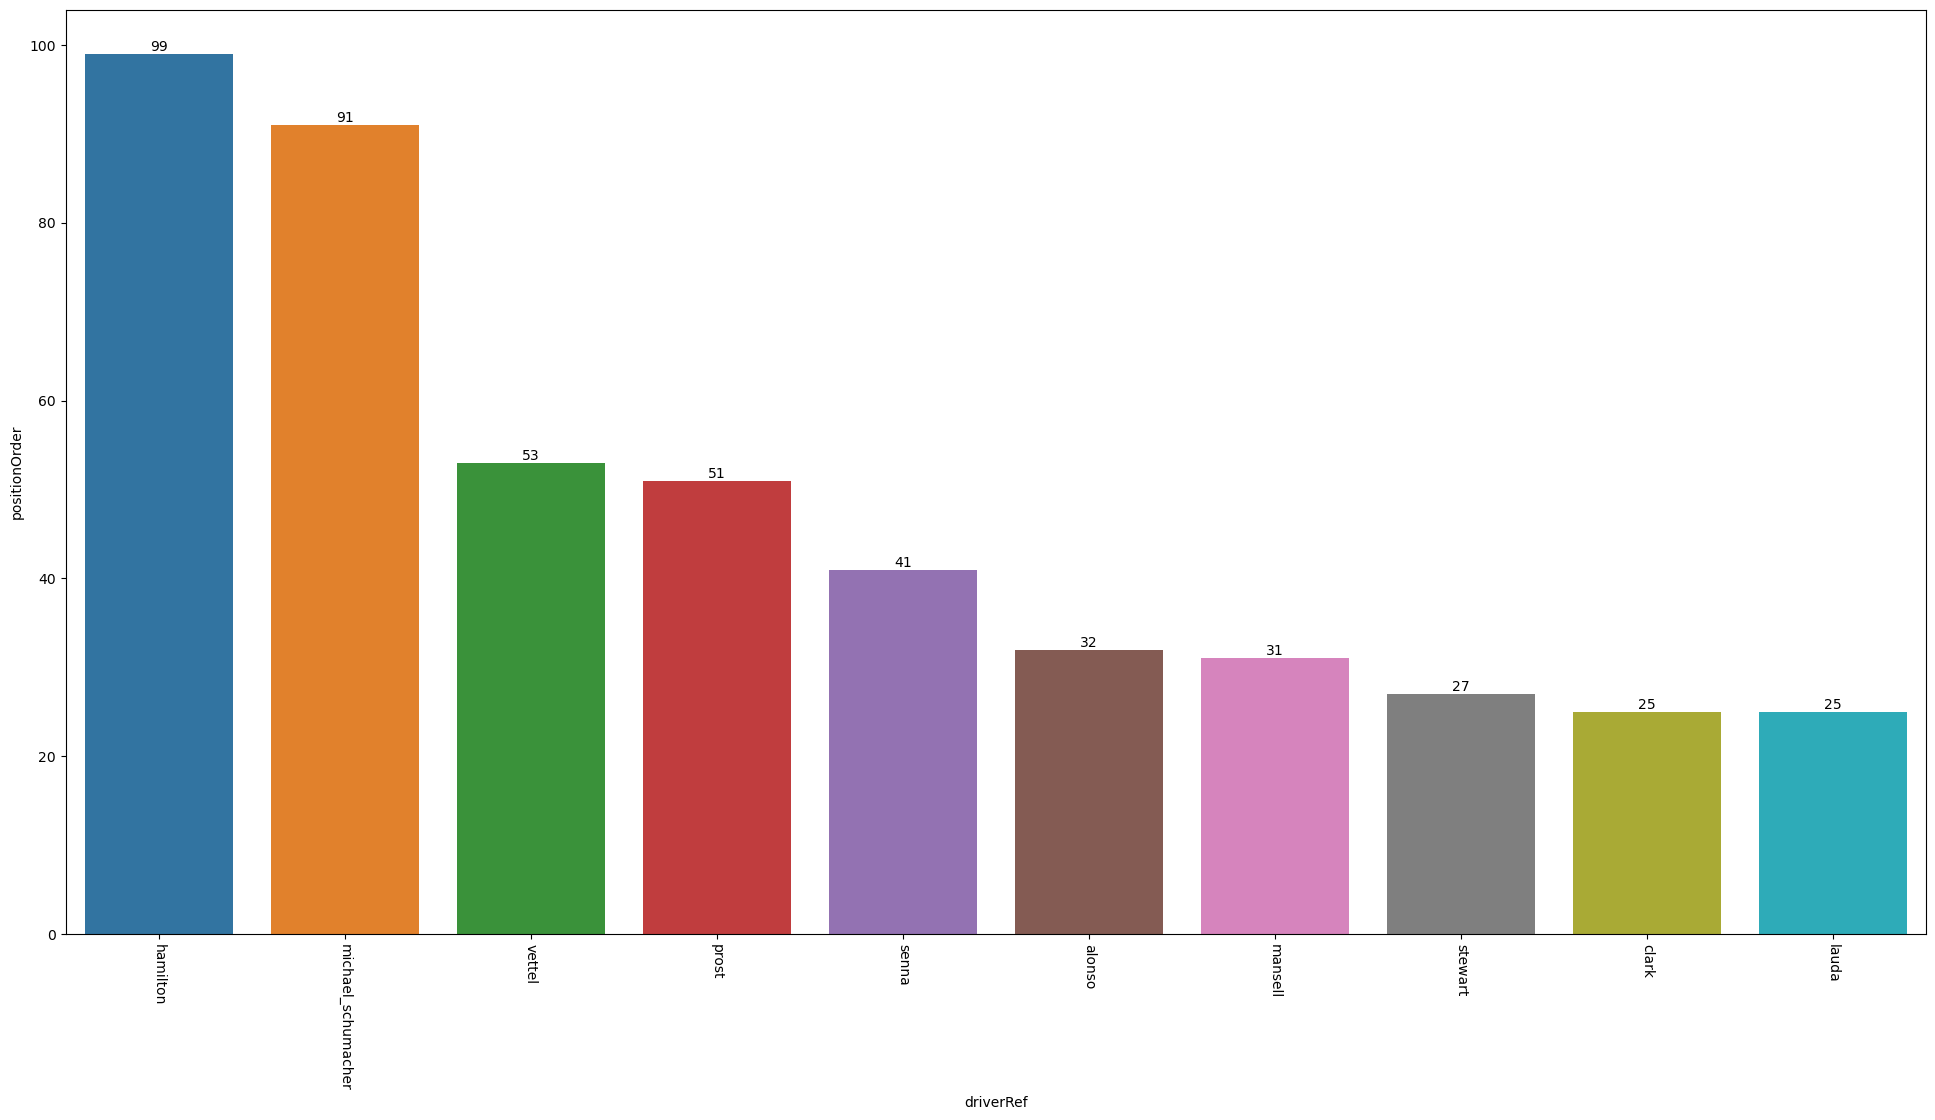

In [17]:
plt.figure(figsize=(24,12))
ax = sns.barplot(
    x = "driverRef",
    y = "positionOrder",    
    data = raceWinners.head(10)
)
ax.bar_label(ax.containers[0])


ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)

# Nationalitées 

[Text(0, 0.5, 'Nombre'), Text(0.5, 1.0, 'Nationalité les plus représentées')]

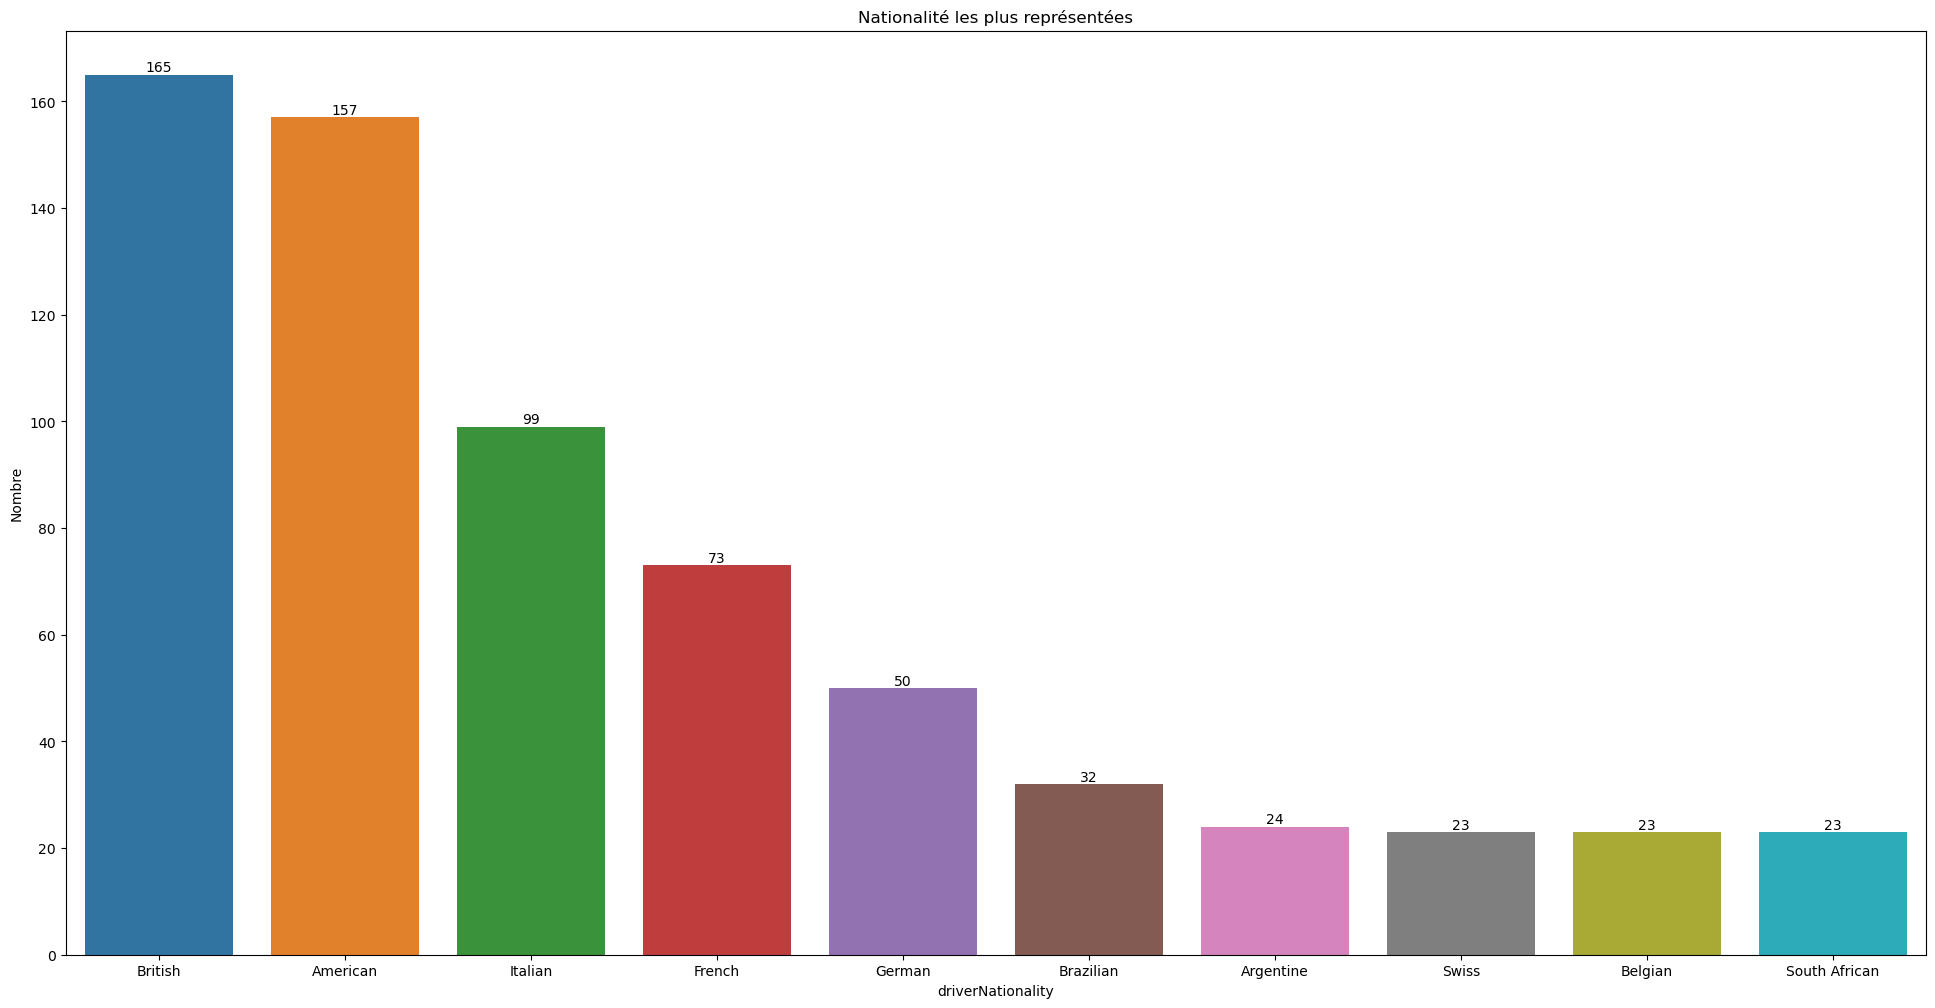

In [18]:
plt.figure(figsize=(24,12))
Nationality = drivers.groupby('driverNationality')['driverSurname'].count().sort_values(ascending=False).to_frame().reset_index()

ax = sns.barplot(
    x = "driverNationality",
    y = "driverSurname",
    data =  Nationality.head(10)
)
ax.bar_label(ax.containers[0])

ax.set(ylabel='Nombre',title = "Nationalité les plus représentées")




In [19]:
raceWinnersNationality = pd.merge(results,races[['raceId','year','name']],on = 'raceId',how = 'left')
raceWinnersNationality = pd.merge(raceWinnersNationality,drivers[['driverId','driverRef','driverNationality']],on = 'driverId',how ='left')

raceWinnersNationality = raceWinnersNationality.loc[raceWinnersNationality['positionOrder']==1].groupby('driverNationality')['positionOrder'].count().sort_values(ascending=False).to_frame().reset_index()
raceWinnersNationality


,driverNationality,positionOrder
0,British,304
1,German,179
2,Brazilian,101
3,French,81
4,Finnish,56
5,Italian,43
6,Australian,42
7,Austrian,41
8,Argentine,38
9,American,33


[Text(0, 0, 'British'),
 Text(1, 0, 'German'),
 Text(2, 0, 'Brazilian'),
 Text(3, 0, 'French'),
 Text(4, 0, 'Finnish'),
 Text(5, 0, 'Italian'),
 Text(6, 0, 'Australian'),
 Text(7, 0, 'Austrian'),
 Text(8, 0, 'Argentine'),
 Text(9, 0, 'American')]

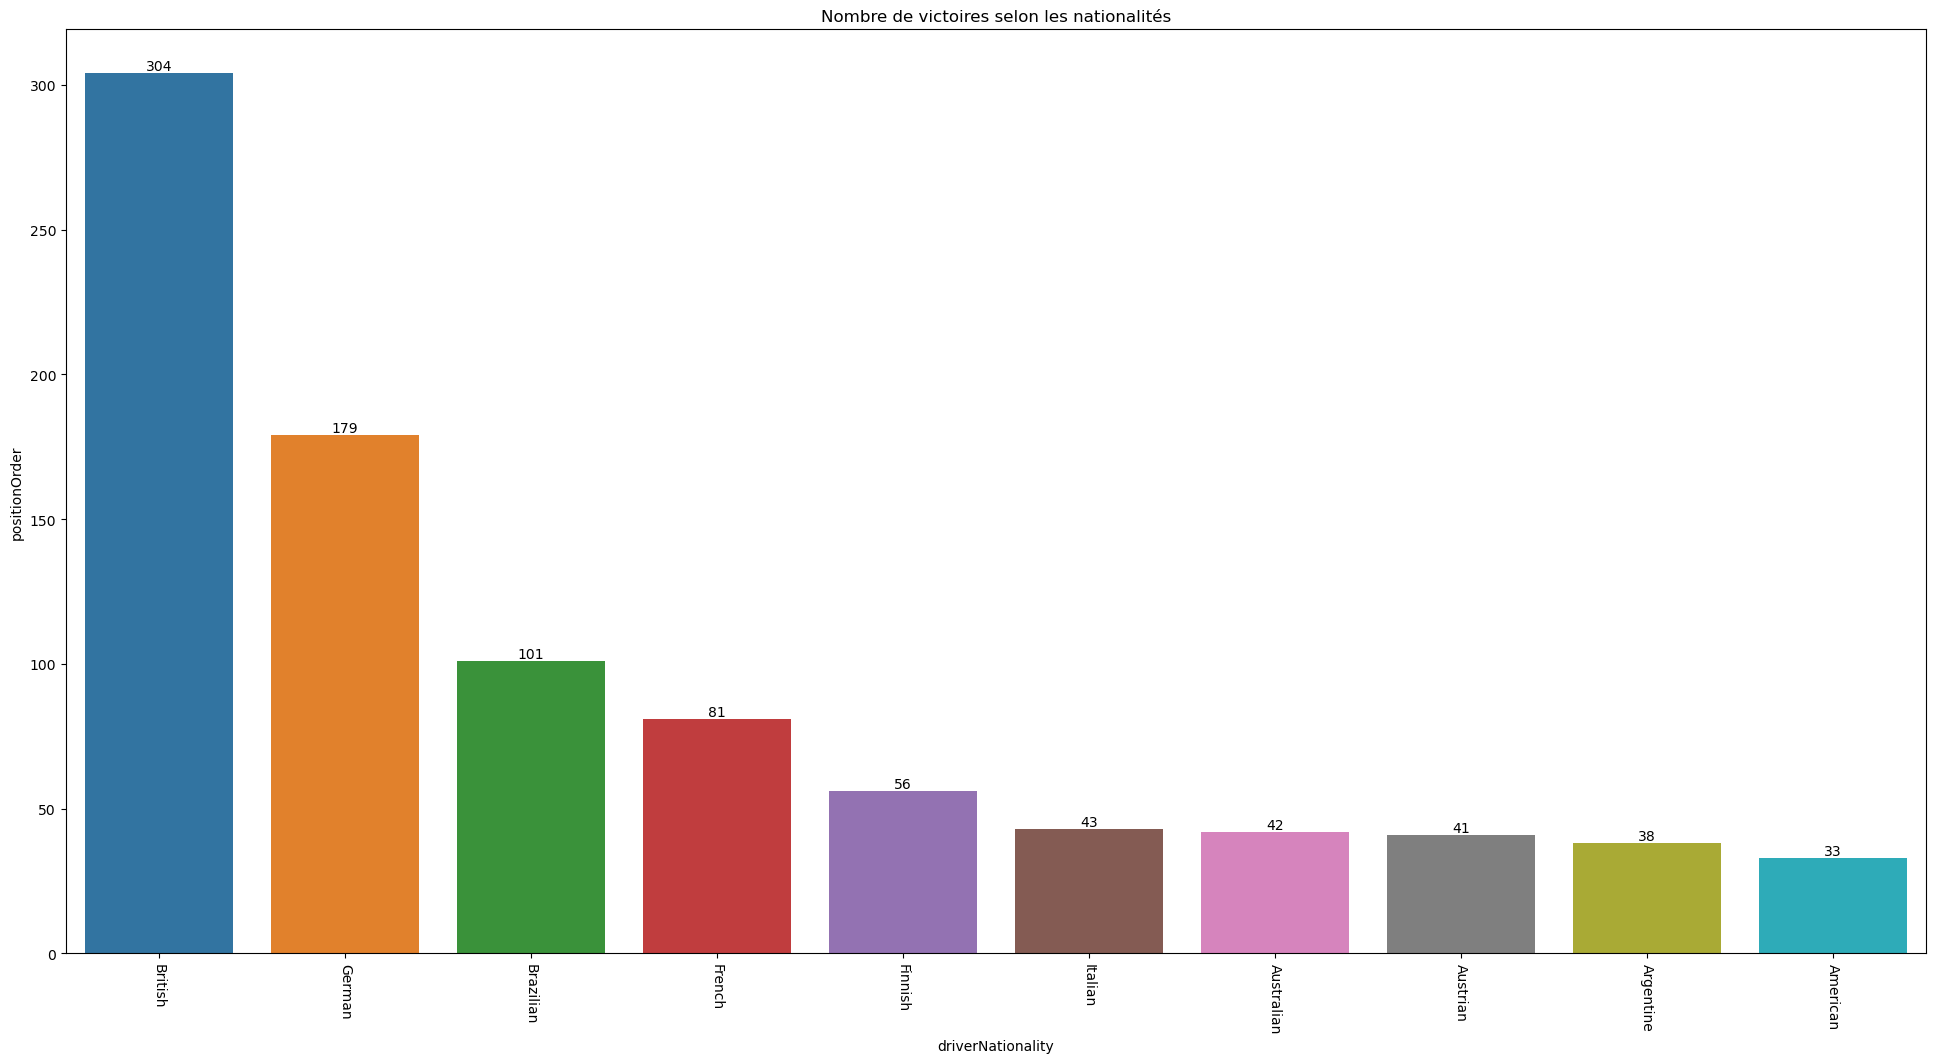

In [20]:
plt.figure(figsize=(24,12))
ax = sns.barplot(
    x = "driverNationality",
    y = "positionOrder",    
    data = raceWinnersNationality.head(10)
)
ax.set_title("Nombre de victoires selon les nationalités")
ax.bar_label(ax.containers[0])

ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)

# Vitesses des F1 au cours du temps

In [21]:
speedRace = pd.merge(lap_times, races, on = "raceId")
speedRace = pd.merge(speedRace,results, on = ["raceId", "driverId"])
speedRace = speedRace[(speedRace["statusId"] == 1) | speedRace["statusId"].between(11,19)]
speedRace

,raceId,driverId,lap,lapPosition,lap_timesMilliseconds,year,round,circuitId,name,date,...,positionOrder,points,laps,raceTime,raceTimeMilliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,841,20,1,1,98109,2011,1,1,Australian Grand Prix,2011-03-27,...,1,25.0,58,1:29:30.259,5370259.0,44.0,4.0,89844.0,212.488,1
1,841,20,2,1,93006,2011,1,1,Australian Grand Prix,2011-03-27,...,1,25.0,58,1:29:30.259,5370259.0,44.0,4.0,89844.0,212.488,1
2,841,20,3,1,92713,2011,1,1,Australian Grand Prix,2011-03-27,...,1,25.0,58,1:29:30.259,5370259.0,44.0,4.0,89844.0,212.488,1
3,841,20,4,1,92803,2011,1,1,Australian Grand Prix,2011-03-27,...,1,25.0,58,1:29:30.259,5370259.0,44.0,4.0,89844.0,212.488,1
4,841,20,5,1,92342,2011,1,1,Australian Grand Prix,2011-03-27,...,1,25.0,58,1:29:30.259,5370259.0,44.0,4.0,89844.0,212.488,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504912,1064,849,66,16,80271,2021,13,39,Dutch Grand Prix,2021-09-05,...,16,0.0,70,NaN,NaN,25.0,18.0,75790.0,202.301,12
504913,1064,849,67,16,80392,2021,13,39,Dutch Grand Prix,2021-09-05,...,16,0.0,70,NaN,NaN,25.0,18.0,75790.0,202.301,12
504914,1064,849,68,16,79387,2021,13,39,Dutch Grand Prix,2021-09-05,...,16,0.0,70,NaN,NaN,25.0,18.0,75790.0,202.301,12
504915,1064,849,69,15,78777,2021,13,39,Dutch Grand Prix,2021-09-05,...,16,0.0,70,NaN,NaN,25.0,18.0,75790.0,202.301,12


In [22]:
mostCommonCircuits = races["circuitId"].value_counts()[:10]
mostCommonCircuits


14    71
6     67
9     56
13    54
20    41
7     40
18    38
10    37
11    36
22    32
Name: circuitId, dtype: int64

1. En général

Text(0.5, 1.0, 'Evolution de la vitesse au cours du temps')

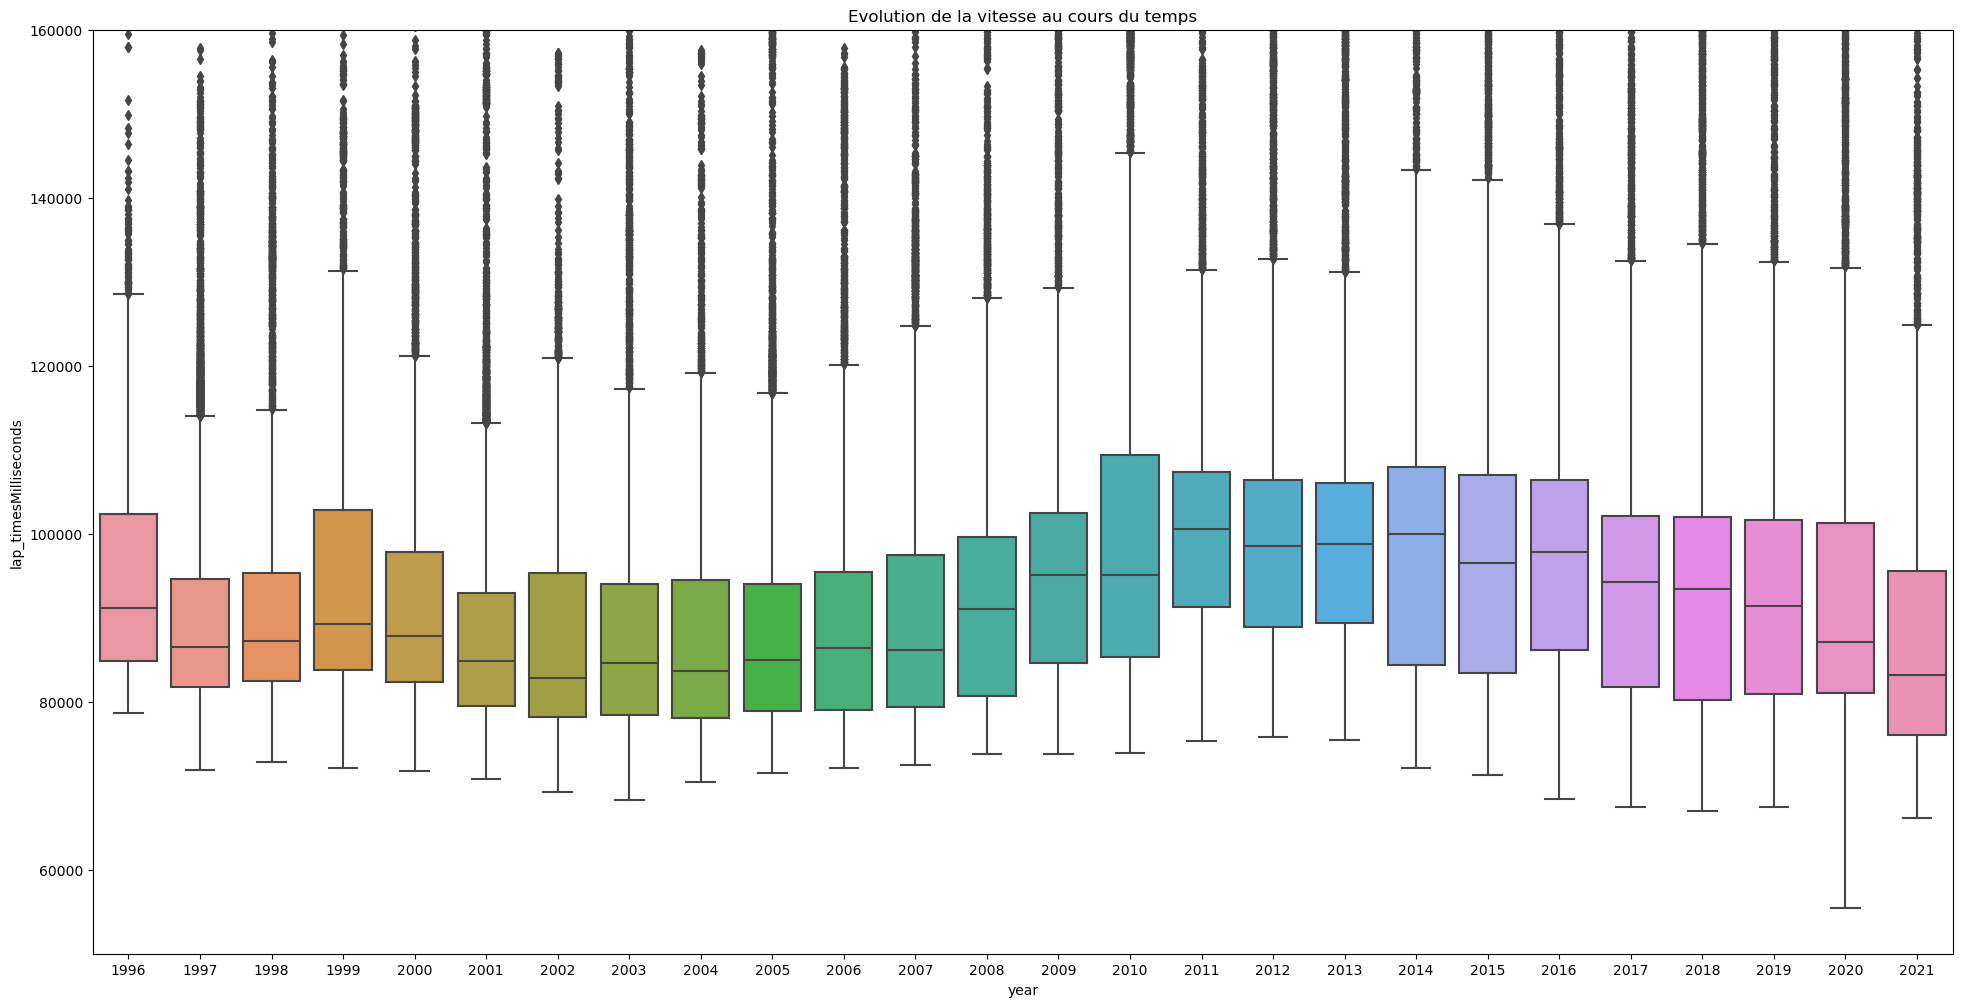

In [23]:
GeneralSpeed = speedRace[["lap_timesMilliseconds","fastestLapTime", "year"]]
GeneralSpeed = GeneralSpeed.sort_values(by = ["year"])
plt.figure(figsize=(24,12))

ax = sns.boxplot(
    x = 'year',
    y = 'lap_timesMilliseconds',
    data = GeneralSpeed
)
ax.set_ylim([50000, 160000])
ax.set_title("Evolution de la vitesse au cours du temps")

2. Sur des circuits spécifiques 

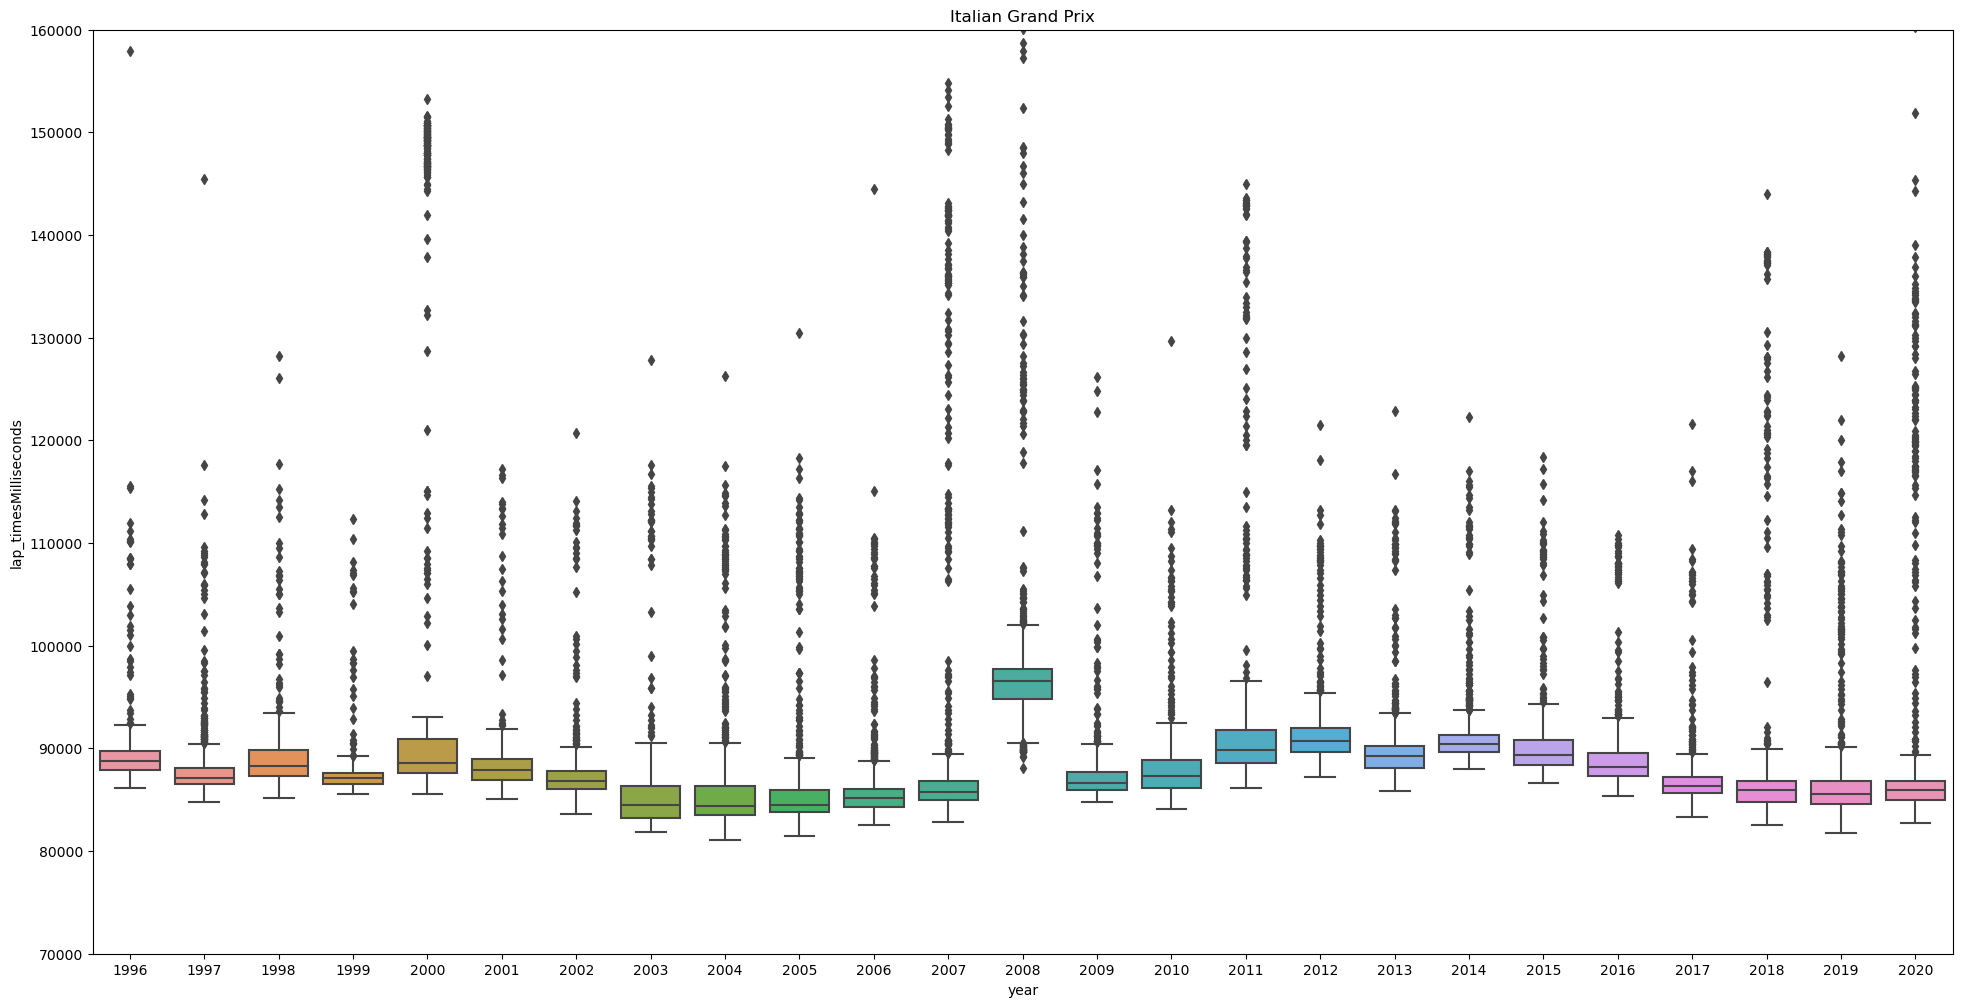

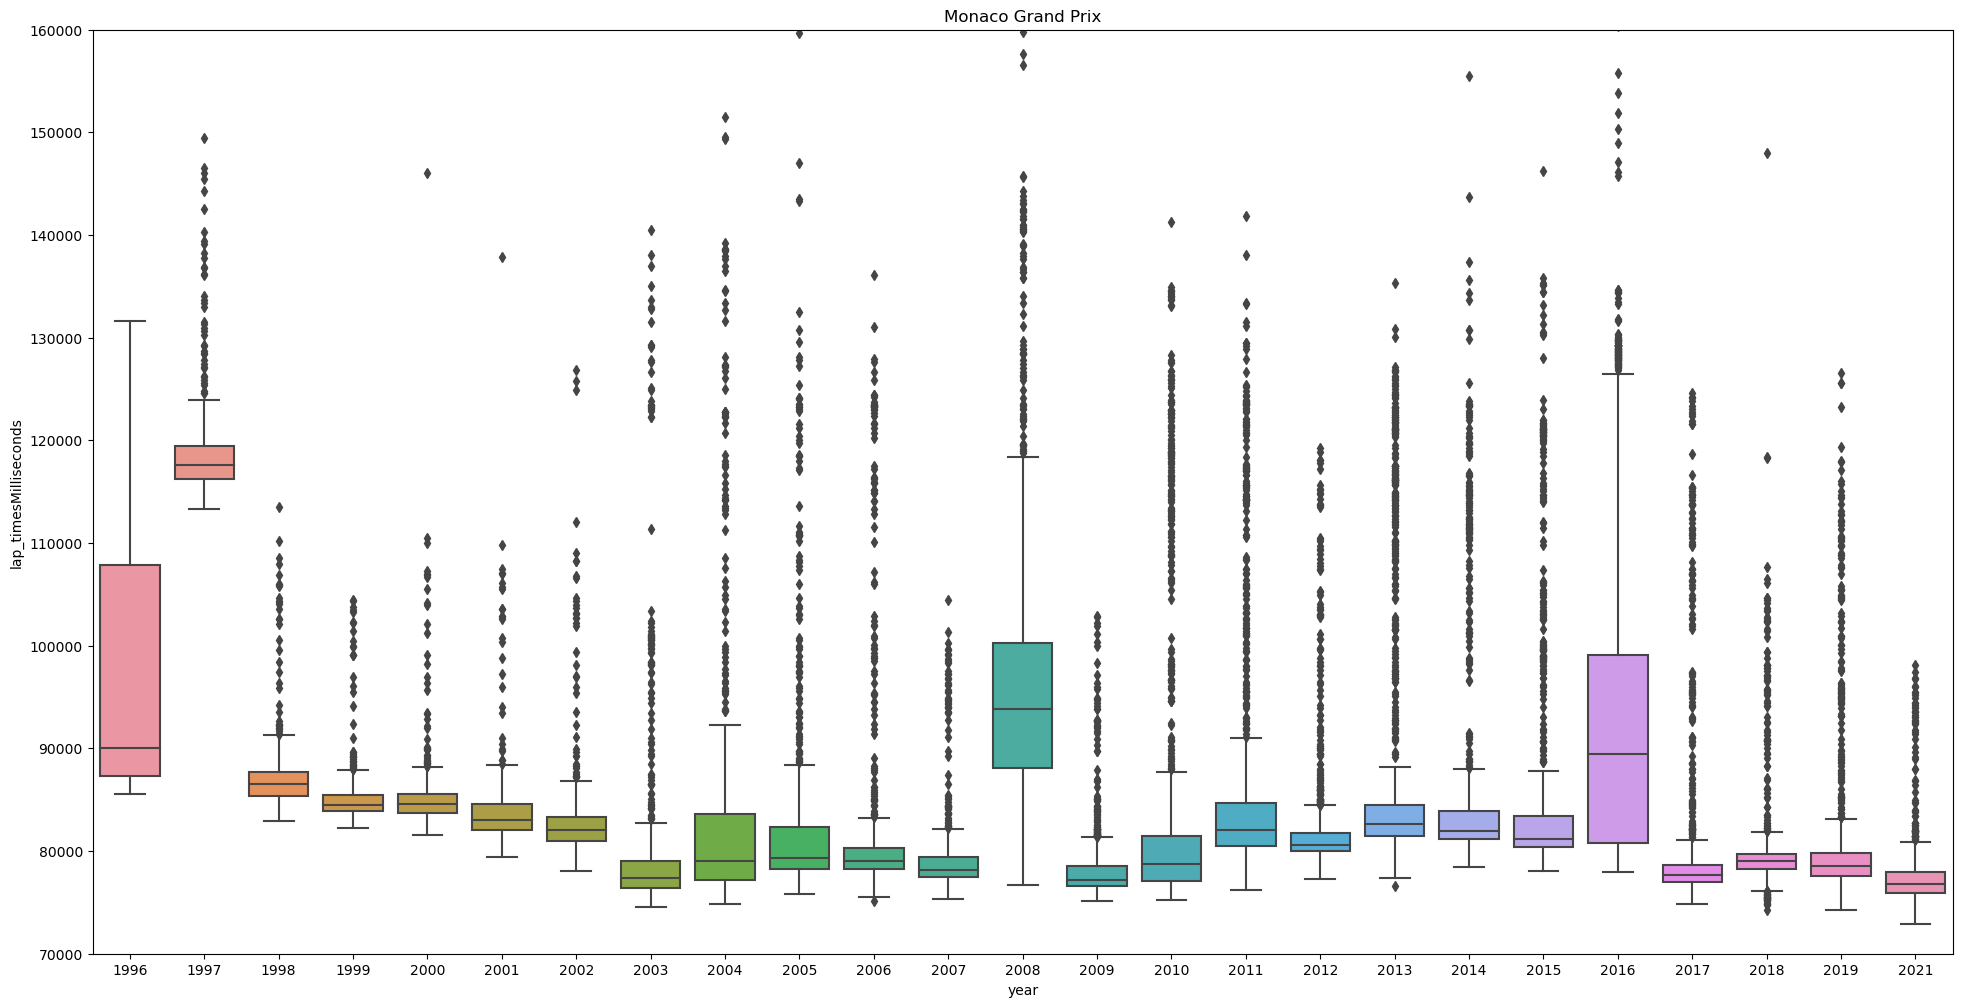

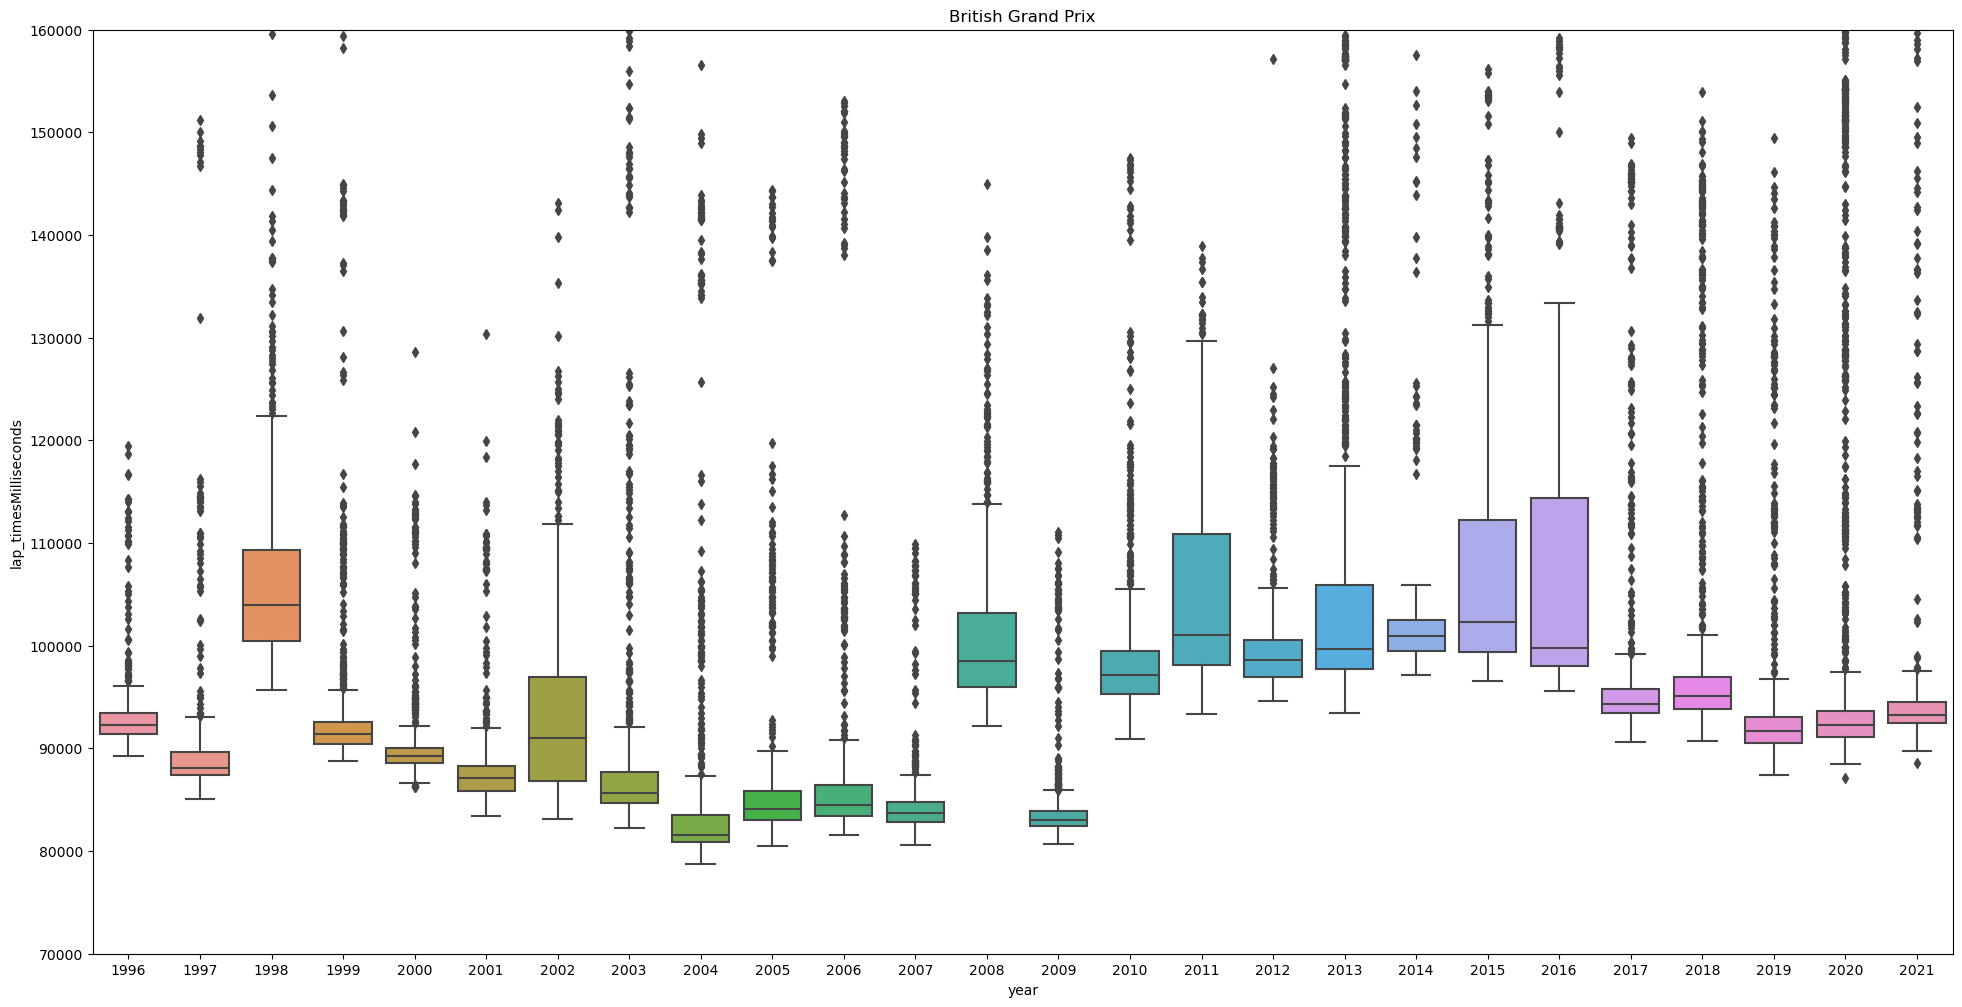

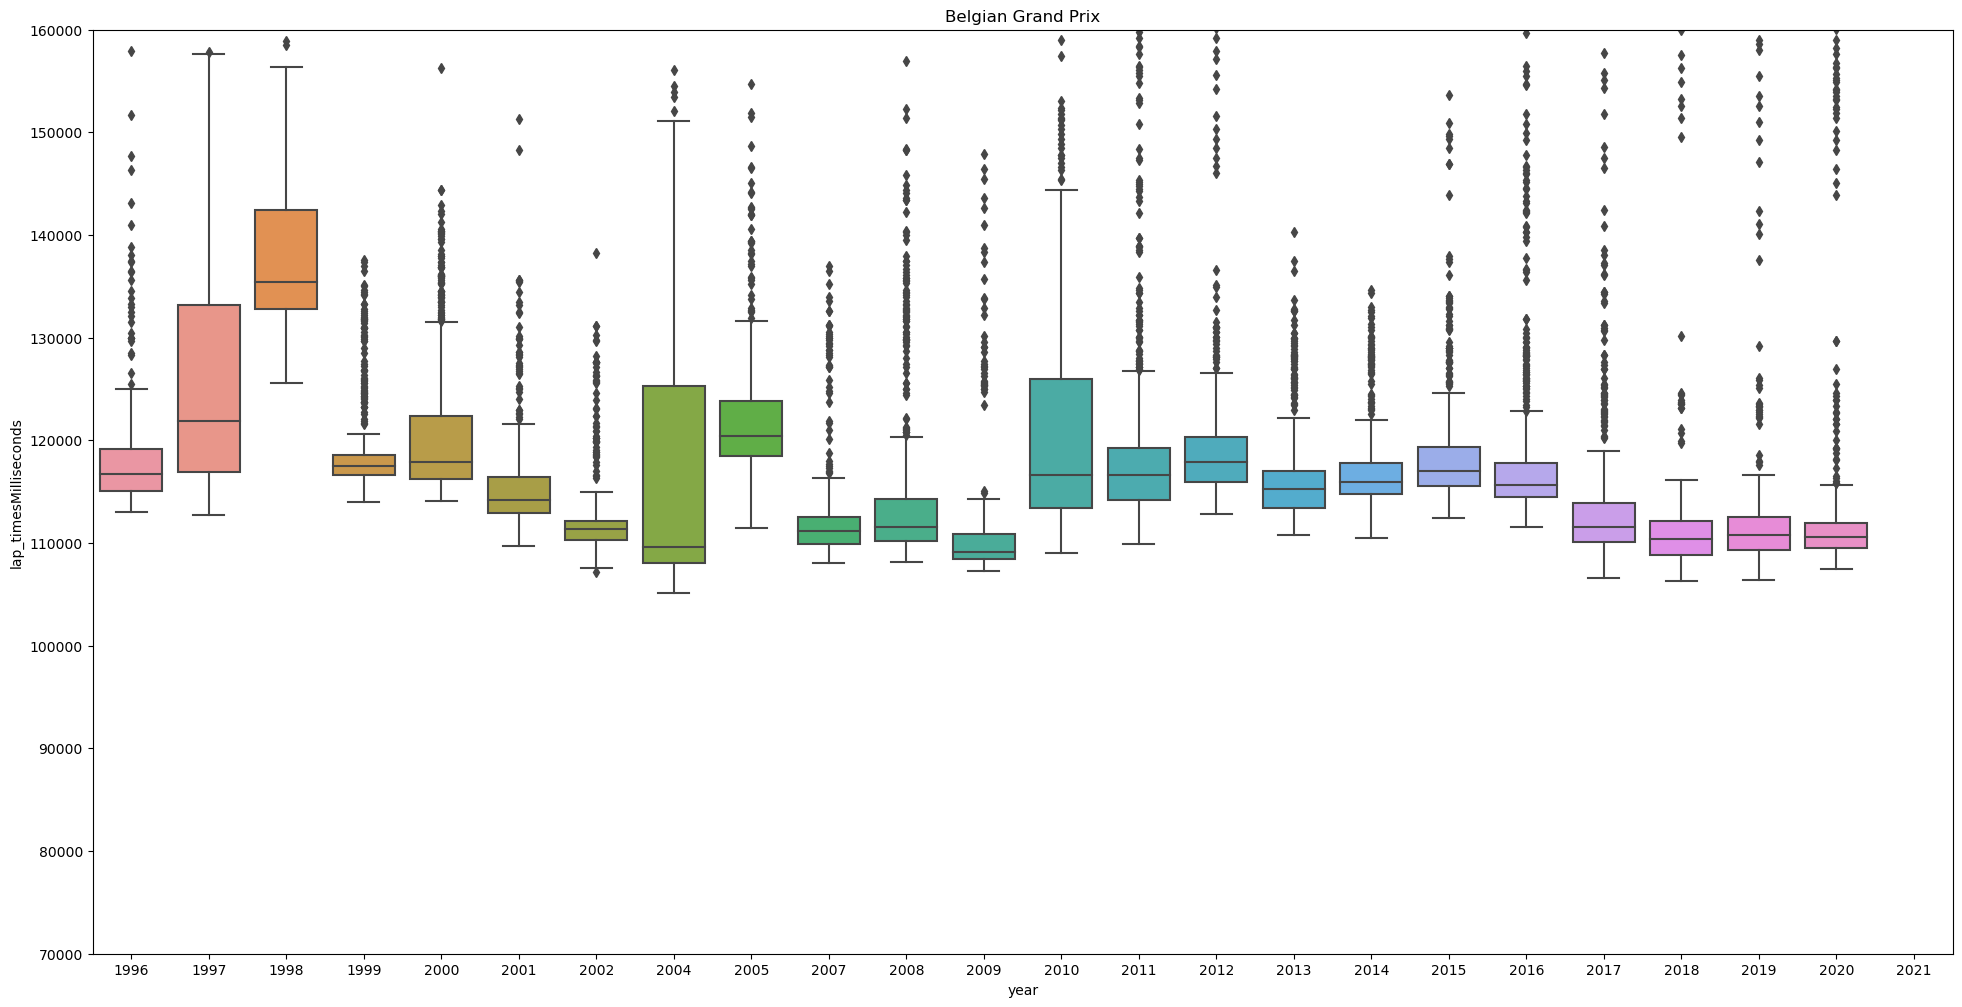

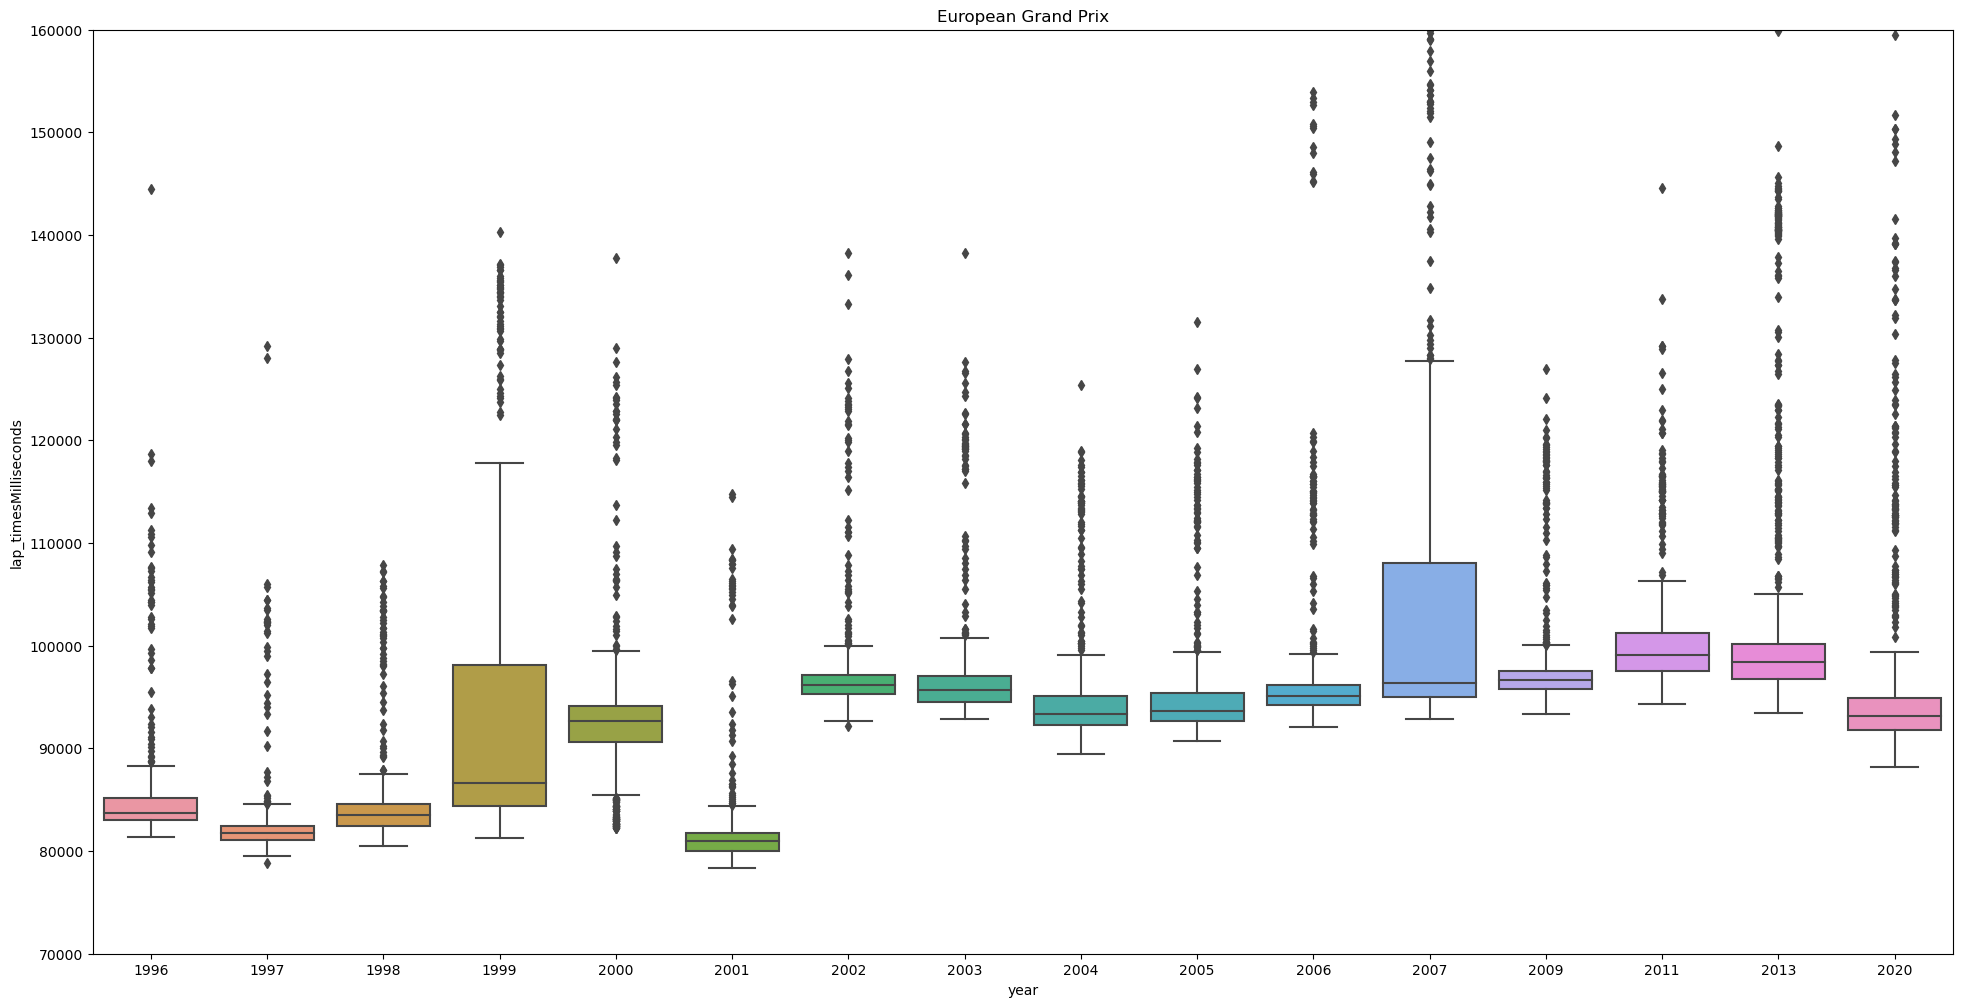

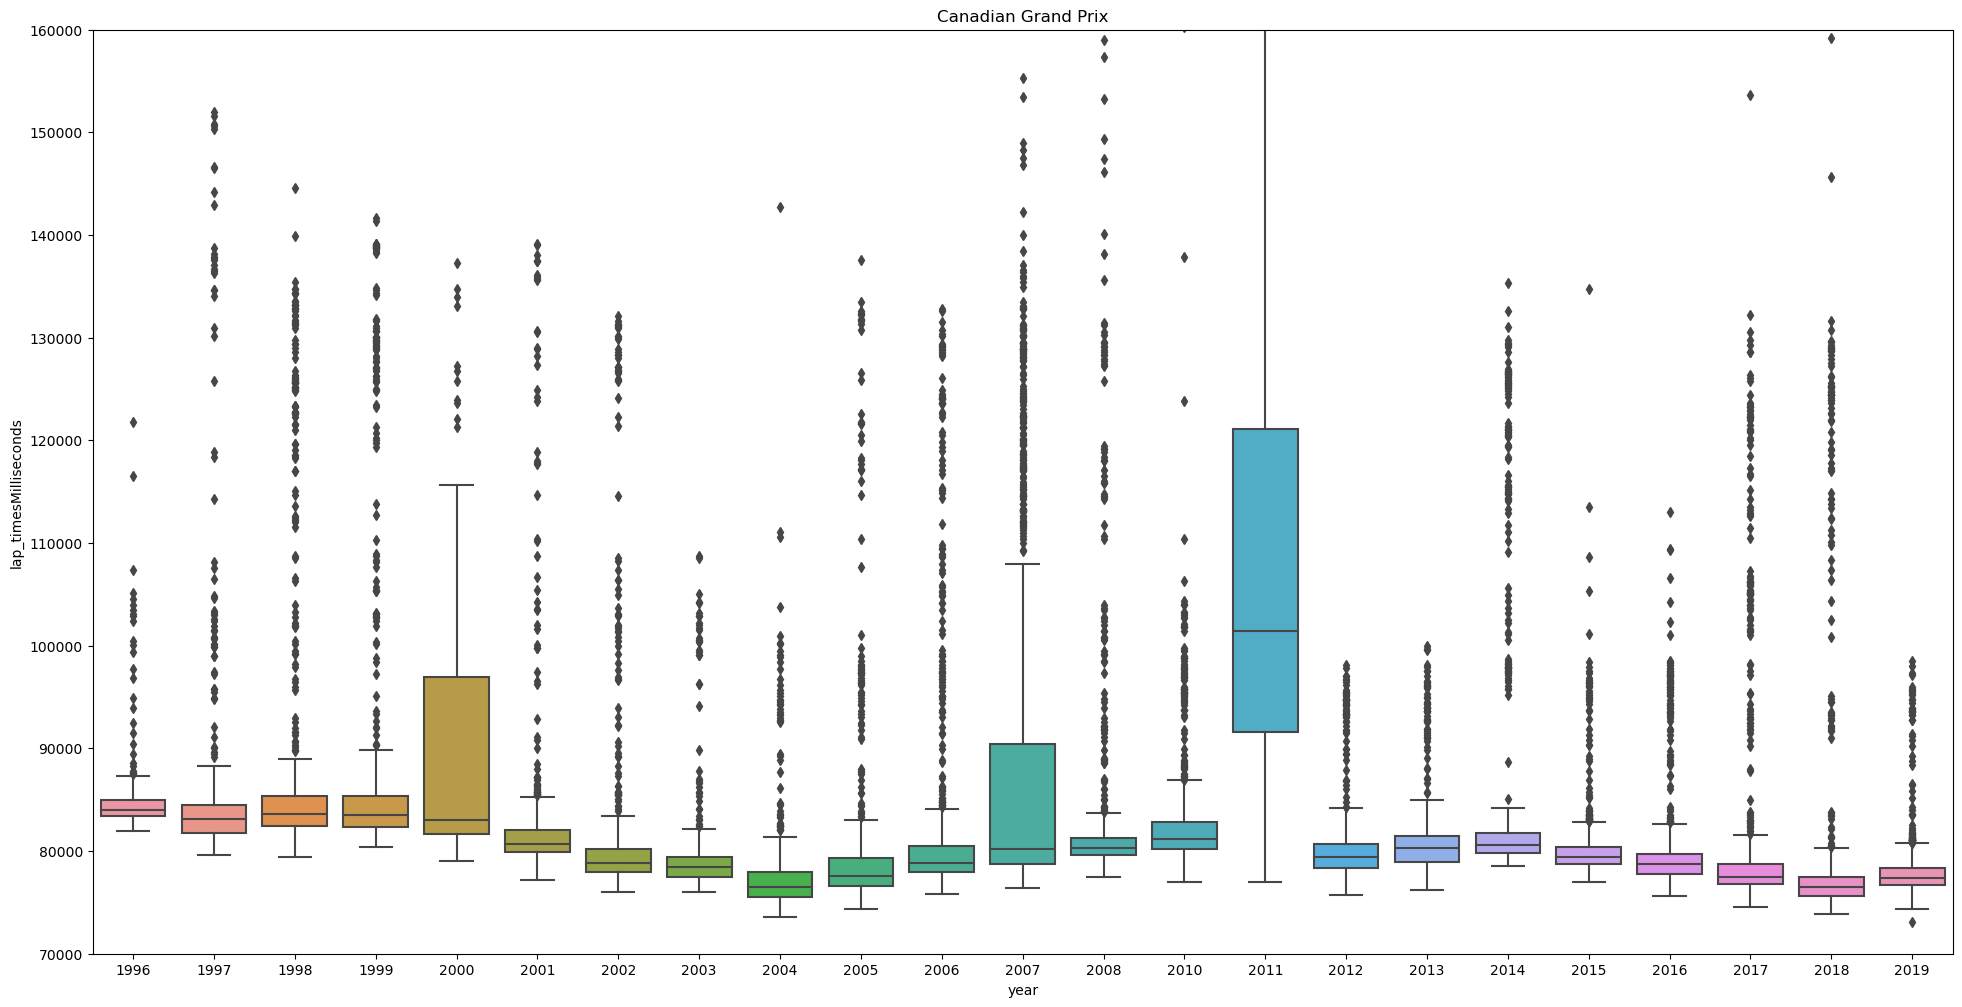

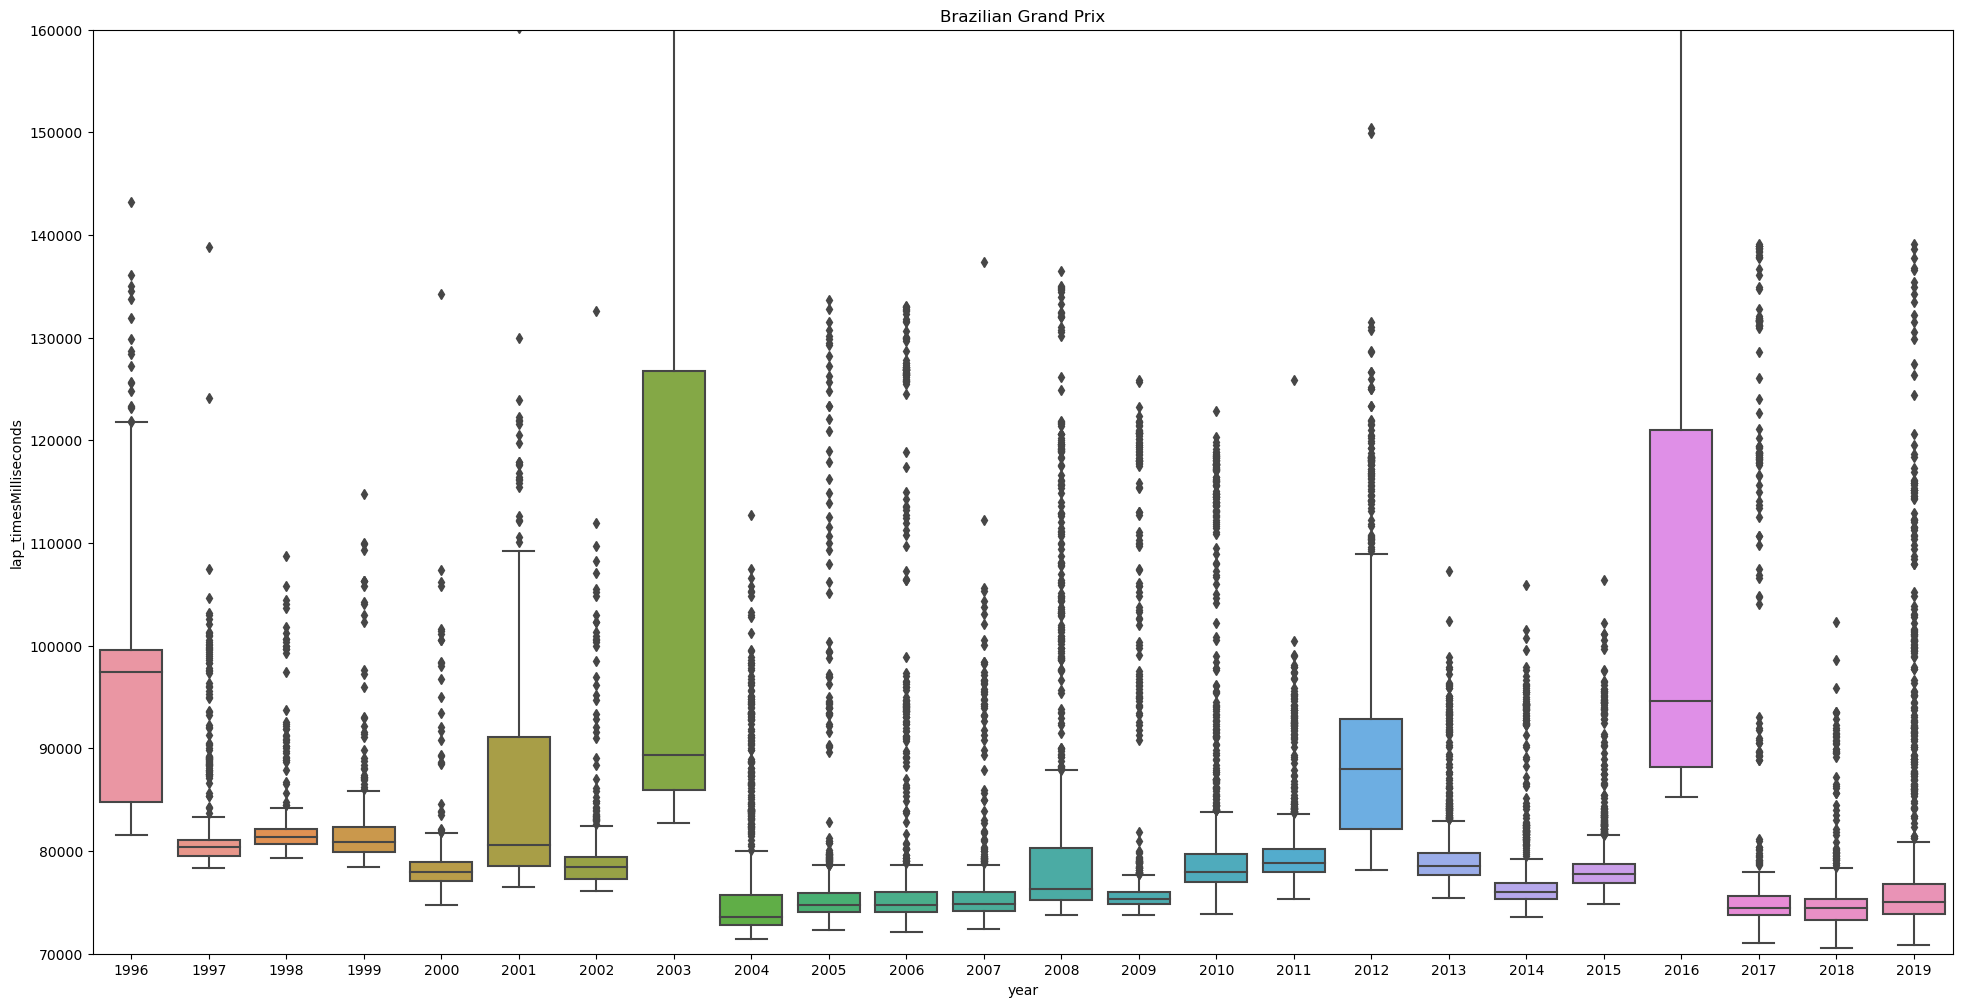

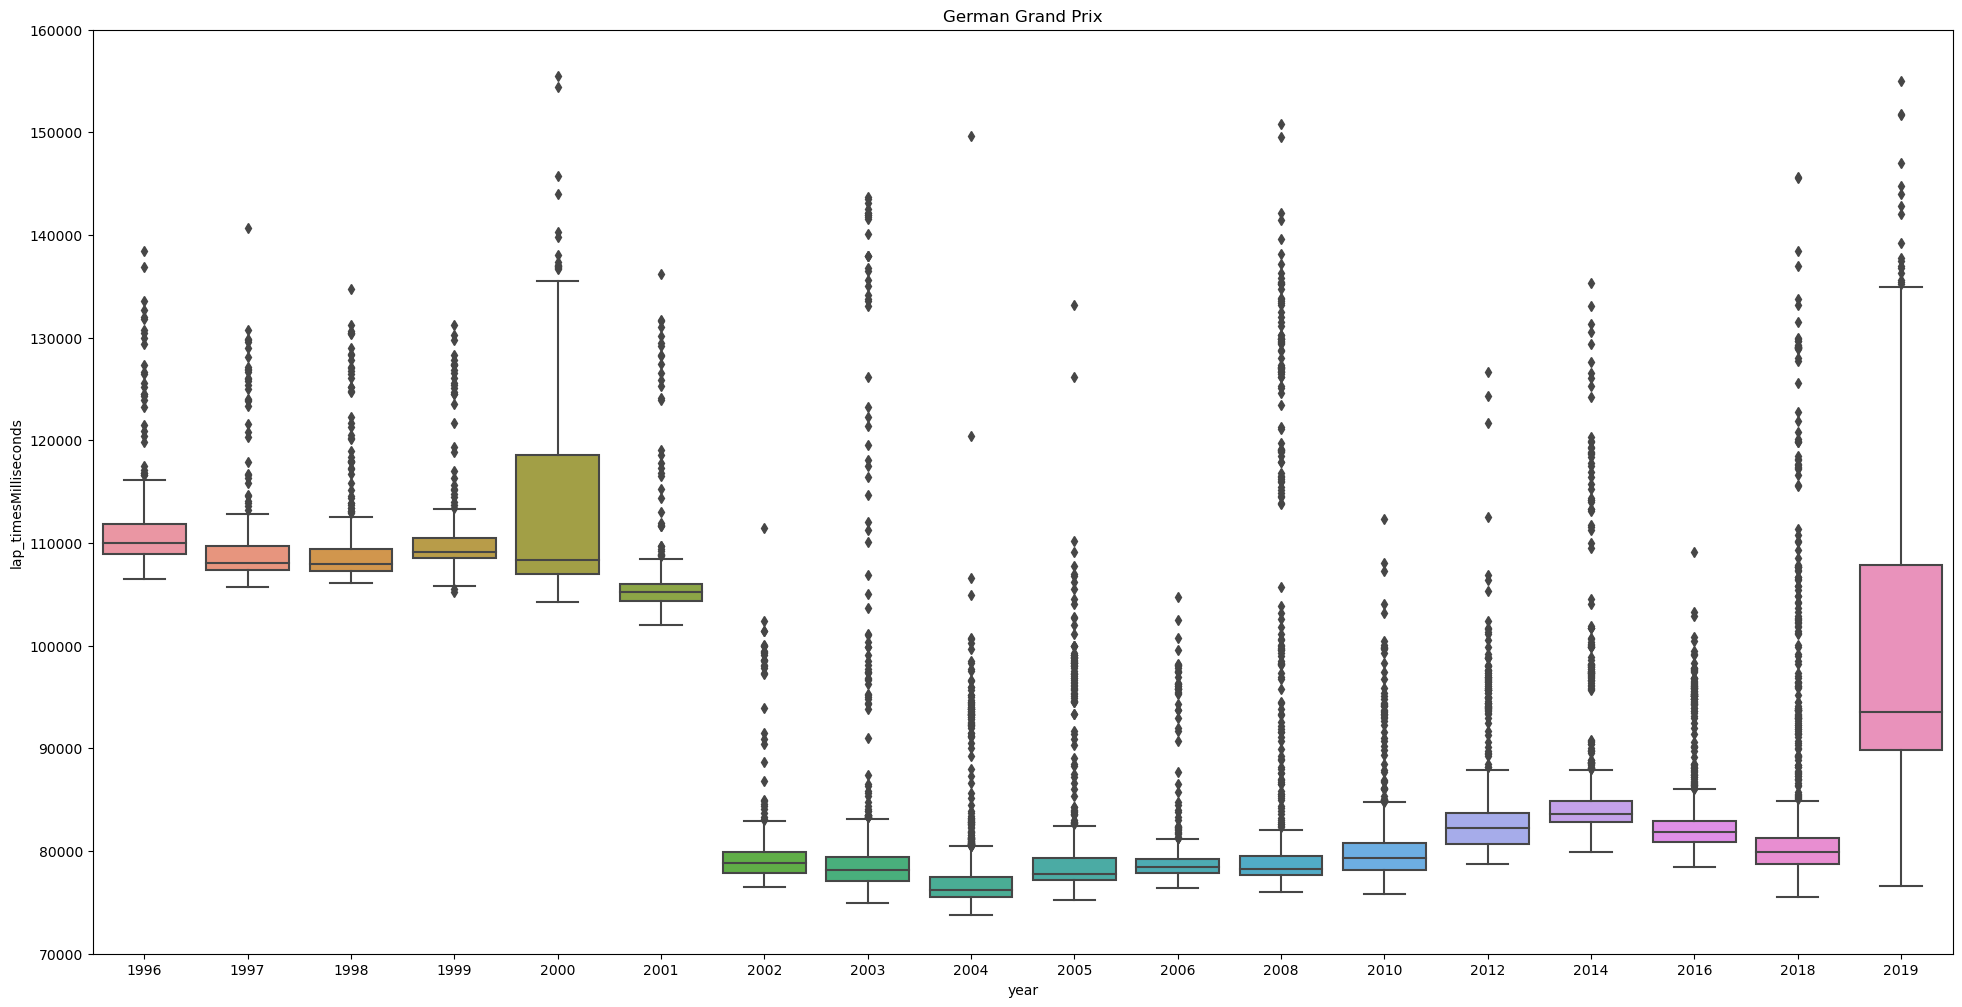

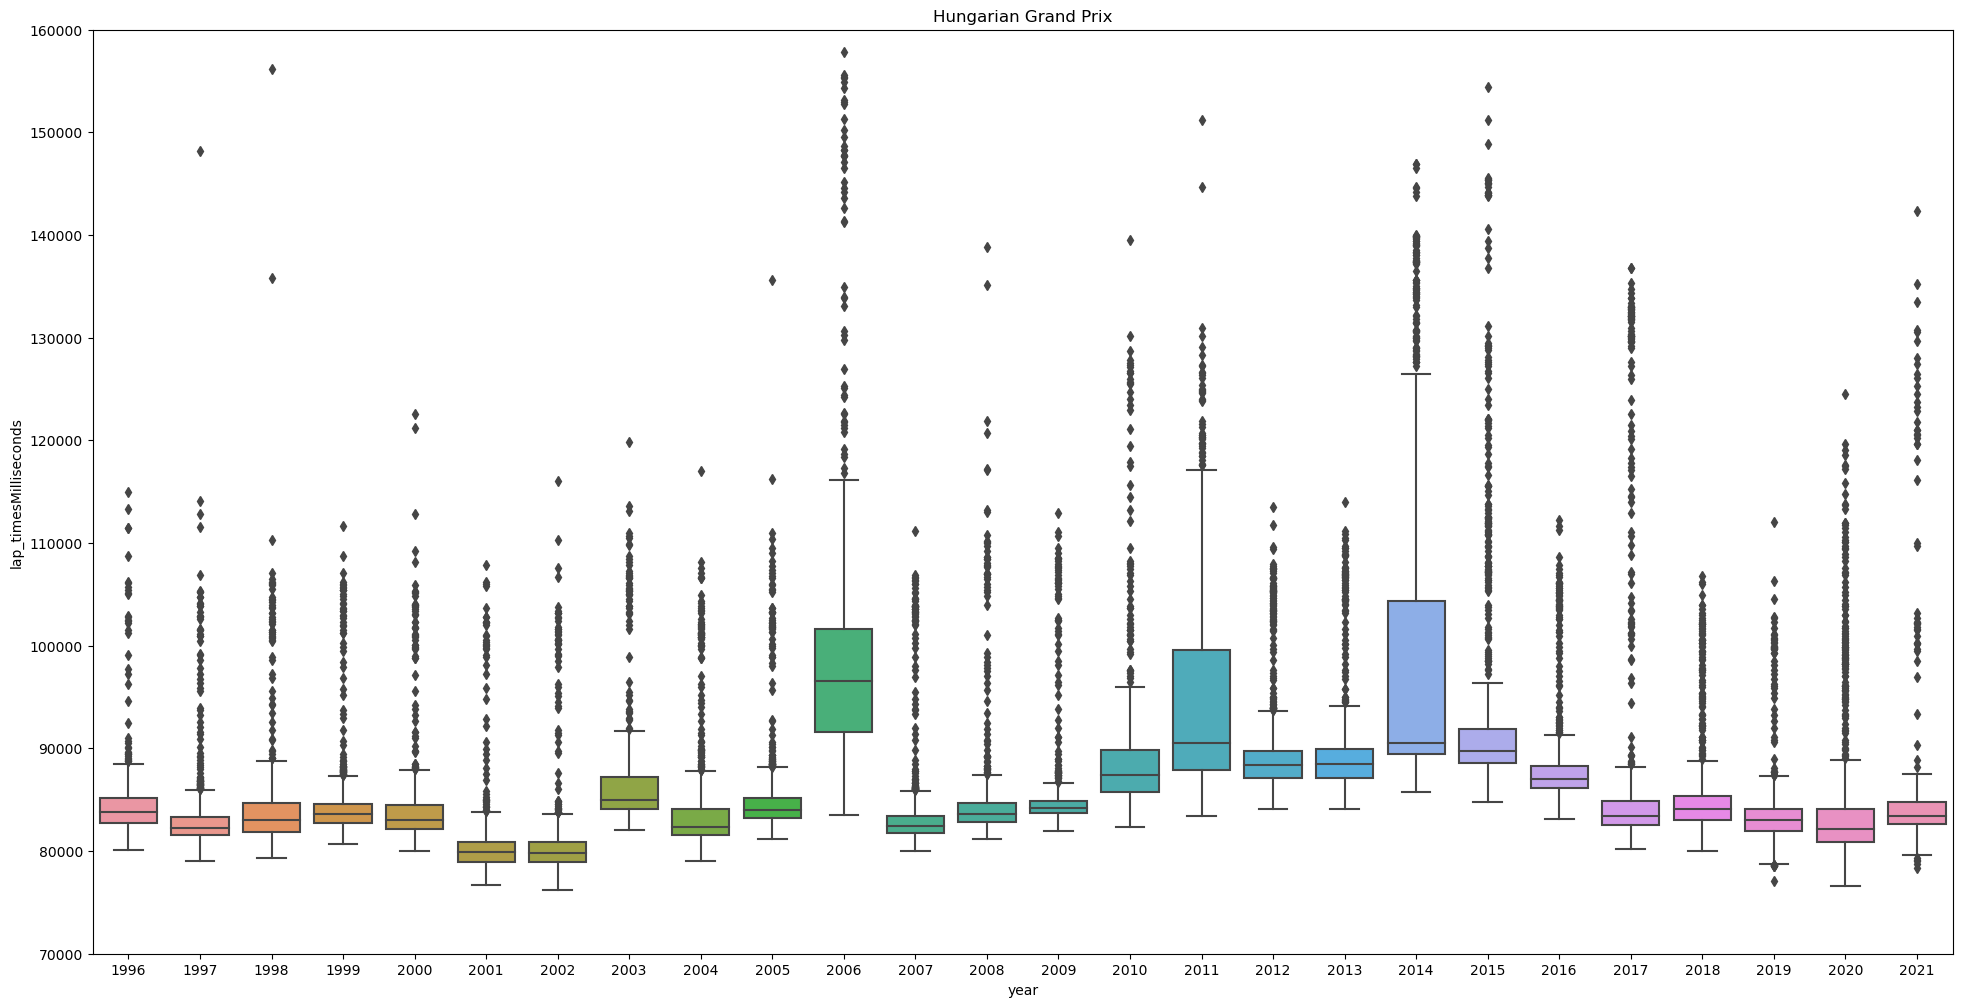

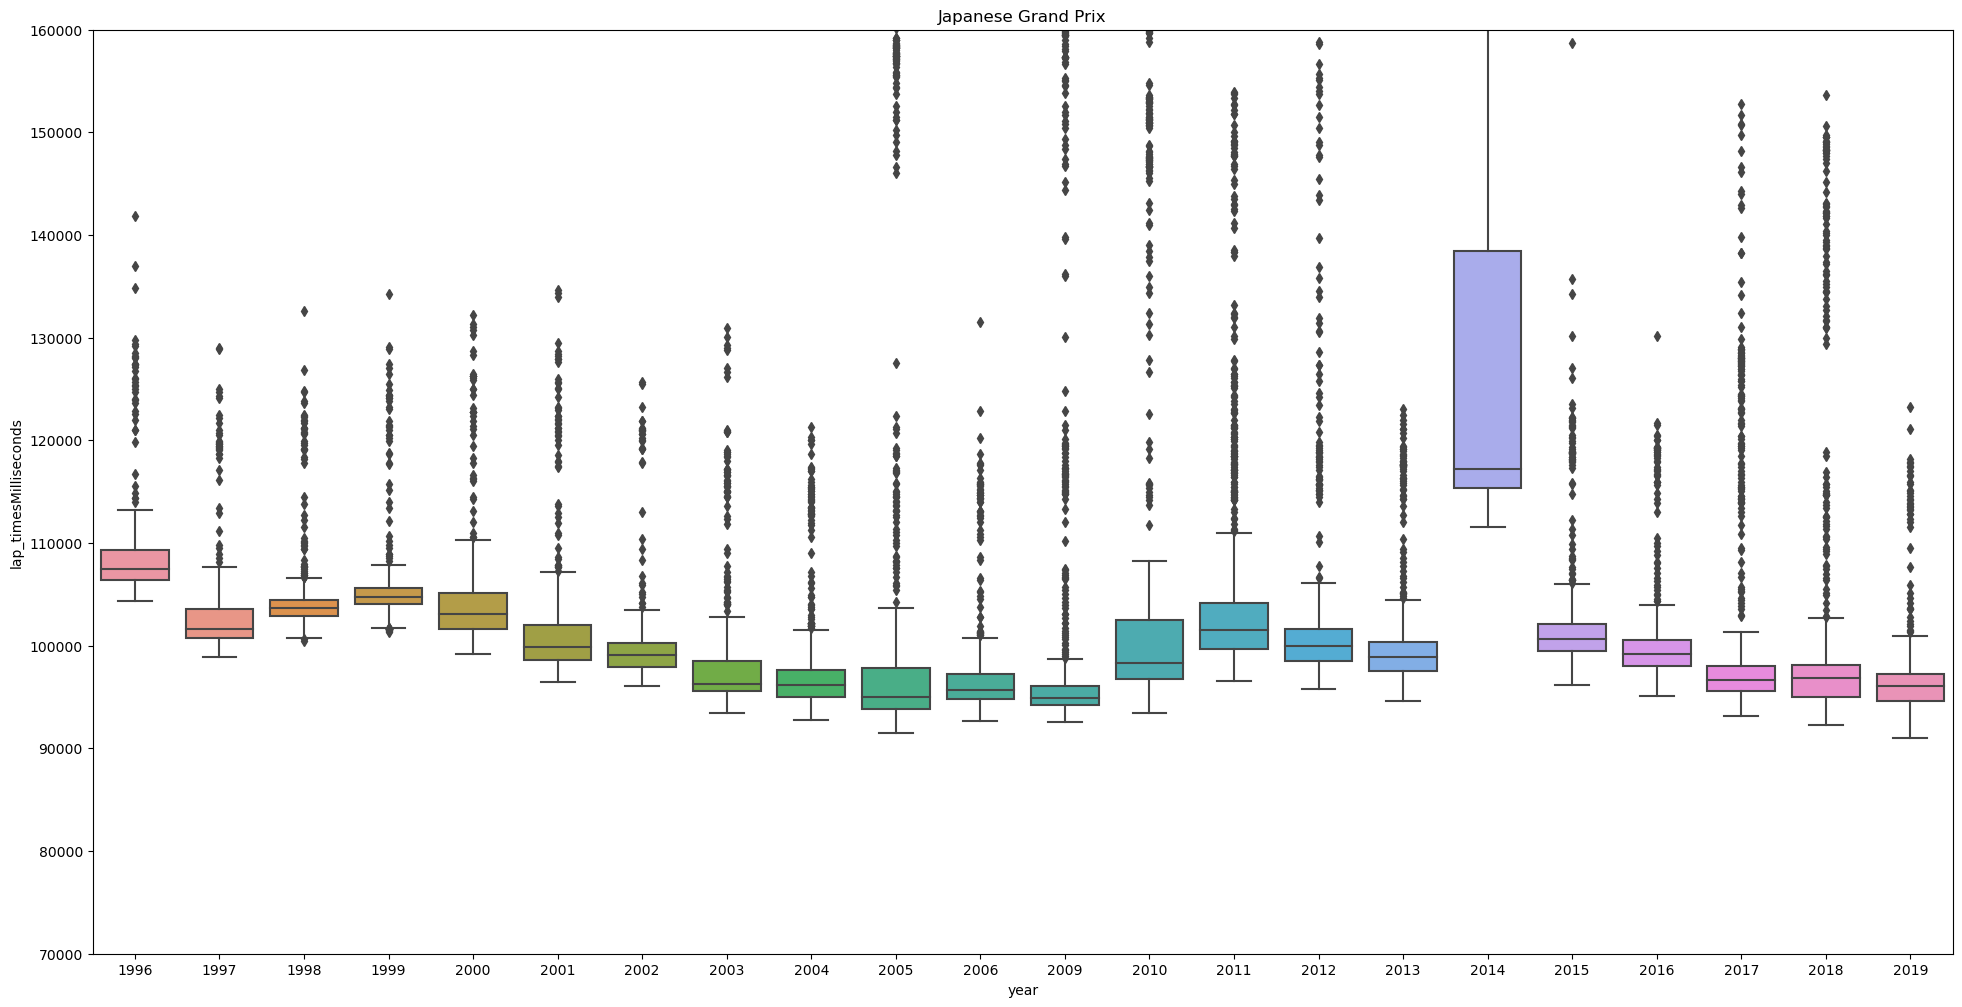

In [24]:
for circuitId in mostCommonCircuits.index:
    plt.figure(figsize=(24,12))

    current_circuit = speedRace[speedRace["circuitId"] == circuitId]
    current_circuit = current_circuit.sort_values(by = ["year"])
    ax = sns.boxplot(
        x = 'year',
        y = 'lap_timesMilliseconds',
        data = current_circuit
    )
    ax.set_ylim([70000, 160000])
    ax.set_title(current_circuit['name'].unique()[0])
    plt.show()

Explications

Pourquoi un peu moins rapide après 2004?
Arrivée de nouvelles réglementations en 2005
-Moteur
Un moteur doit endurer deux meetings de grands prix, essais, qualifications et courses comprises contre 1 auparavant

-Aérodynamique 
l'aileron avant est rehaussé de 5 cm en dehors de la zone centrale large de 500 mm, l'aileron arrière est avancé de 15 cm par rapport à l'axe des roues arrières, le diffuseur est 60% moins haut, le plancher est réduit juste devant les roues arrières.
But : réduire les appuis.
Conséquences : les monoplaces ont perdu 25% à 30% d'appui. Aucune équipe n'est parvenue à récupérer la totalité de ce qui a été perdu, malgré un intense travail en soufflerie.

-Pneumatiques
Nouvelle règle : Un seul train de pneumatiques pour le sec doit être utilisé à la fois pour les qualifications, tous les tours de reconnaissance et pour toute la course.
Buts : 1-réduire l'adhérence, 2-diminuer les vitesses de passage en courbe, 3-réduire les coûts


# Pit stops selon les circuits

In [25]:
pit_duration = pd.merge(results[["raceId","driverId","constructorId"]],races[['year','circuitId']],left_on='raceId',right_index=True,how = 'left')
pit_duration = pd.merge(pit_duration,circuits[['circuitName']],left_on = 'circuitId',right_index=True,how = 'left')
pit_duration = pd.merge(pit_duration,constructors[['constructorRef','constructorName']],left_on='constructorId',right_index=True,how='left')
pit_duration = pd.merge(pit_stops,pit_duration,left_on=['raceId','driverId'],right_on=['raceId','driverId'])

pit_duration = pit_duration.dropna(subset=["year"])
pit_duration["seconds"] = pit_duration["pitMilliseconds"] / 1000
pit_duration

,raceId,driverId,stop,lap,pitDuration,pitMilliseconds,constructorId,year,circuitId,circuitName,constructorRef,constructorName,seconds
0,841,153,1,1,26.898,26898,5,2011.0,17.0,Autódromo José Carlos Pace,ferrari,Ferrari,26.898
1,841,153,2,17,24.463,24463,5,2011.0,17.0,Autódromo José Carlos Pace,ferrari,Ferrari,24.463
2,841,153,3,35,26.348,26348,5,2011.0,17.0,Autódromo José Carlos Pace,ferrari,Ferrari,26.348
3,841,30,1,1,25.021,25021,131,2011.0,17.0,Autódromo José Carlos Pace,hwm,HWM,25.021
4,841,30,2,17,23.988,23988,131,2011.0,17.0,Autódromo José Carlos Pace,hwm,HWM,23.988
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8296,1057,8,2,47,15.064,15064,51,2021.0,24.0,Autódromo Juan y Oscar Gálvez,toleman,Toleman,15.064
8297,1057,8,3,48,33:36.437,2016437,51,2021.0,24.0,Autódromo Juan y Oscar Gálvez,toleman,Toleman,2016.437
8298,1057,20,1,18,19.841,19841,117,2021.0,24.0,Autódromo Juan y Oscar Gálvez,moore,Moore,19.841
8299,1057,20,2,47,14.945,14945,117,2021.0,24.0,Autódromo Juan y Oscar Gálvez,moore,Moore,14.945


[Text(0, 0, 'Ferrari'),
 Text(1, 0, 'HWM'),
 Text(2, 0, 'Force India'),
 Text(3, 0, 'Toyota'),
 Text(4, 0, 'Renault'),
 Text(5, 0, 'Honda'),
 Text(6, 0, 'Cooper-Borgward'),
 Text(7, 0, 'Toro Rosso'),
 Text(8, 0, 'BMW Sauber'),
 Text(9, 0, 'BAR'),
 Text(10, 0, 'Lotus F1'),
 Text(11, 0, 'Virgin'),
 Text(12, 0, 'Haas F1 Team'),
 Text(13, 0, 'Racing Point'),
 Text(14, 0, 'Manor Marussia'),
 Text(15, 0, 'AlphaTauri'),
 Text(16, 0, 'Alpine F1 Team'),
 Text(17, 0, 'Toleman'),
 Text(18, 0, 'Moore')]

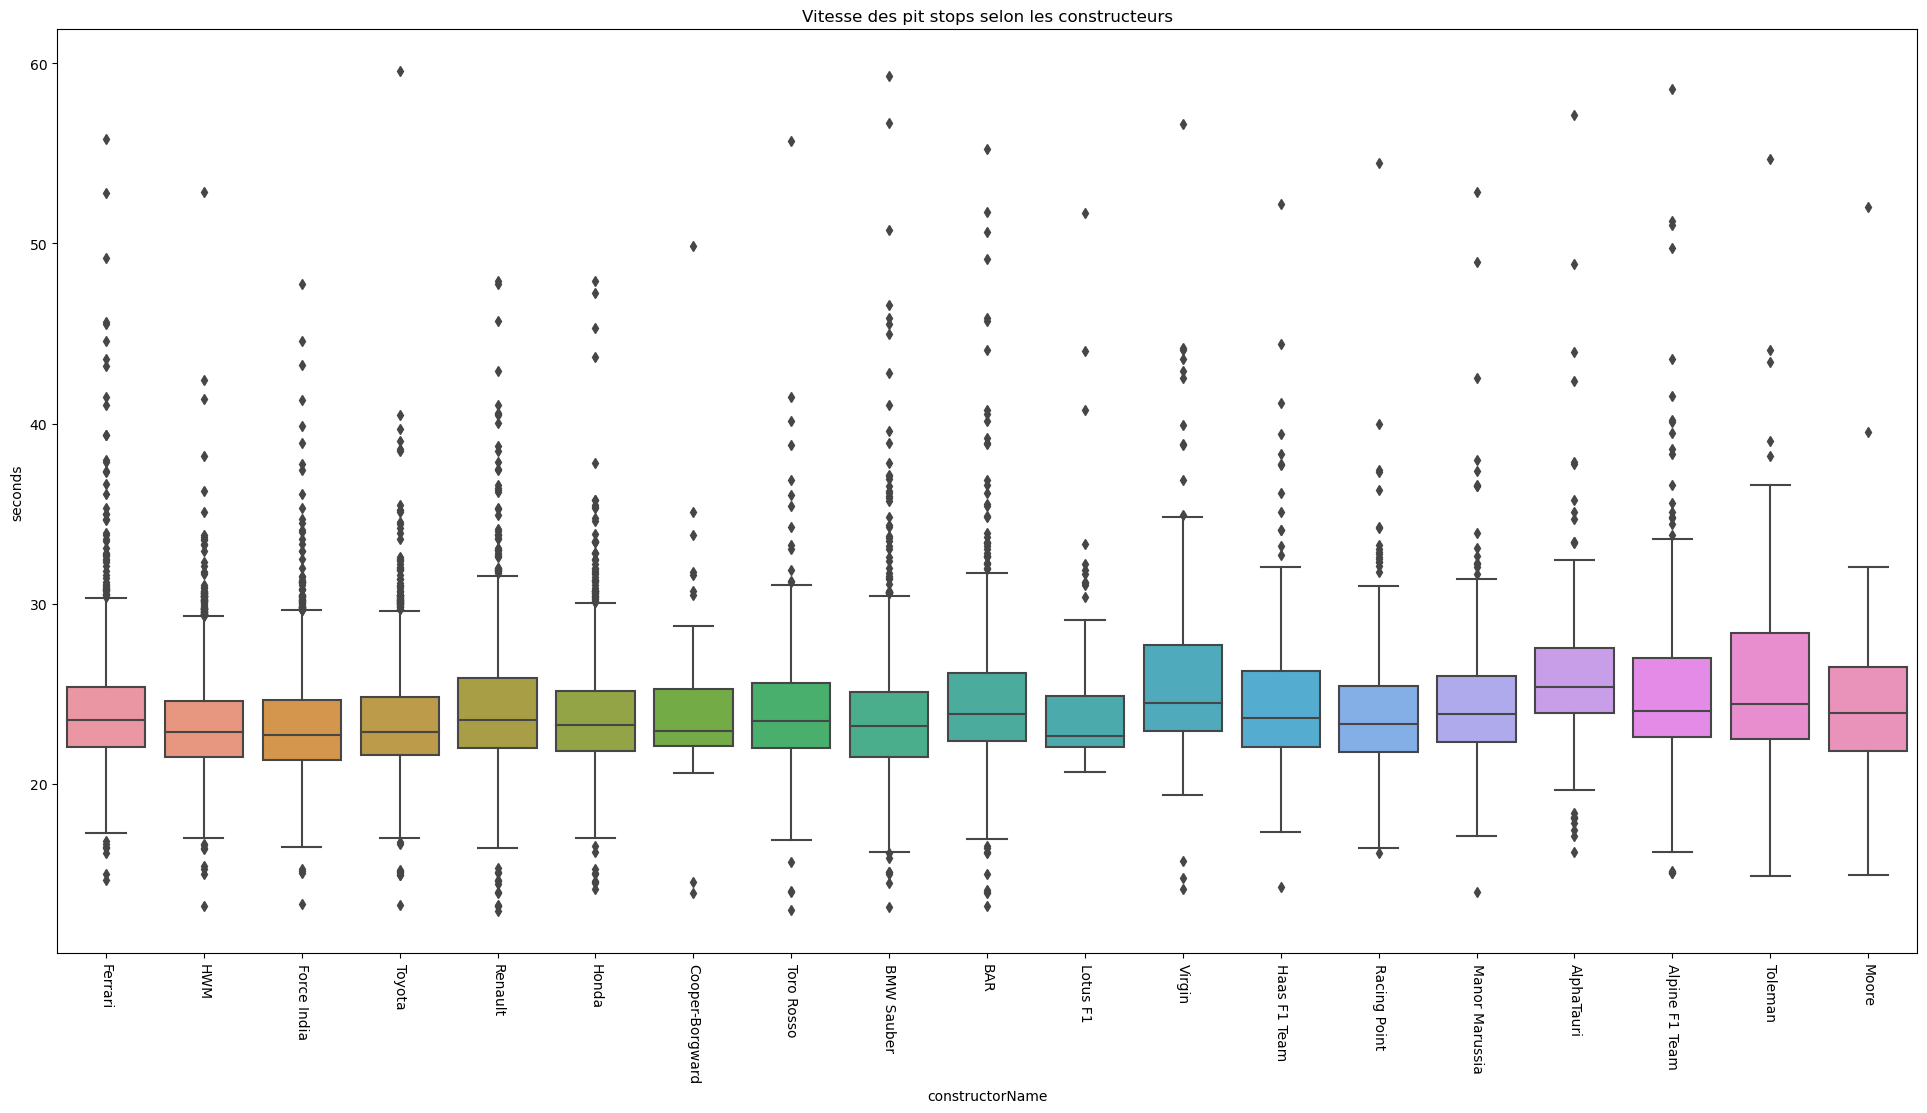

In [26]:
plt.figure(figsize=(24,12))
ax = sns.boxplot(
    x = 'constructorName',
    y = 'seconds',
    data = pit_duration[pit_duration['seconds']<60]
)
ax.set_title("Vitesse des pit stops selon les constructeurs")
ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)

[Text(0, 0, 'Autódromo José Carlos Pace'),
 Text(1, 0, 'Circuit de Monaco'),
 Text(2, 0, 'Istanbul Park'),
 Text(3, 0, 'Circuit Gilles Villeneuve'),
 Text(4, 0, 'Circuit de Nevers Magny-Cours'),
 Text(5, 0, 'Circuit de Spa-Francorchamps'),
 Text(6, 0, 'Hockenheimring'),
 Text(7, 0, 'Autodromo Enzo e Dino Ferrari'),
 Text(8, 0, 'Valencia Street Circuit'),
 Text(9, 0, 'Autodromo Nazionale di Monza'),
 Text(10, 0, 'Marina Bay Street Circuit'),
 Text(11, 0, 'Fuji Speedway'),
 Text(12, 0, 'A1-Ring'),
 Text(13, 0, 'Autódromo Internacional Nelson Piquet'),
 Text(14, 0, 'Circuit of the Americas'),
 Text(15, 0, 'Autódromo Juan y Oscar Gálvez'),
 Text(16, 0, 'Indianapolis Motor Speedway'),
 Text(17, 0, 'Sepang International Circuit'),
 Text(18, 0, 'Bahrain International Circuit'),
 Text(19, 0, 'Circuit de Barcelona-Catalunya'),
 Text(20, 0, 'Hungaroring'),
 Text(21, 0, 'Red Bull Ring'),
 Text(22, 0, 'Sochi Autodrom'),
 Text(23, 0, 'Port Imperial Street Circuit'),
 Text(24, 0, 'Phoenix street cir

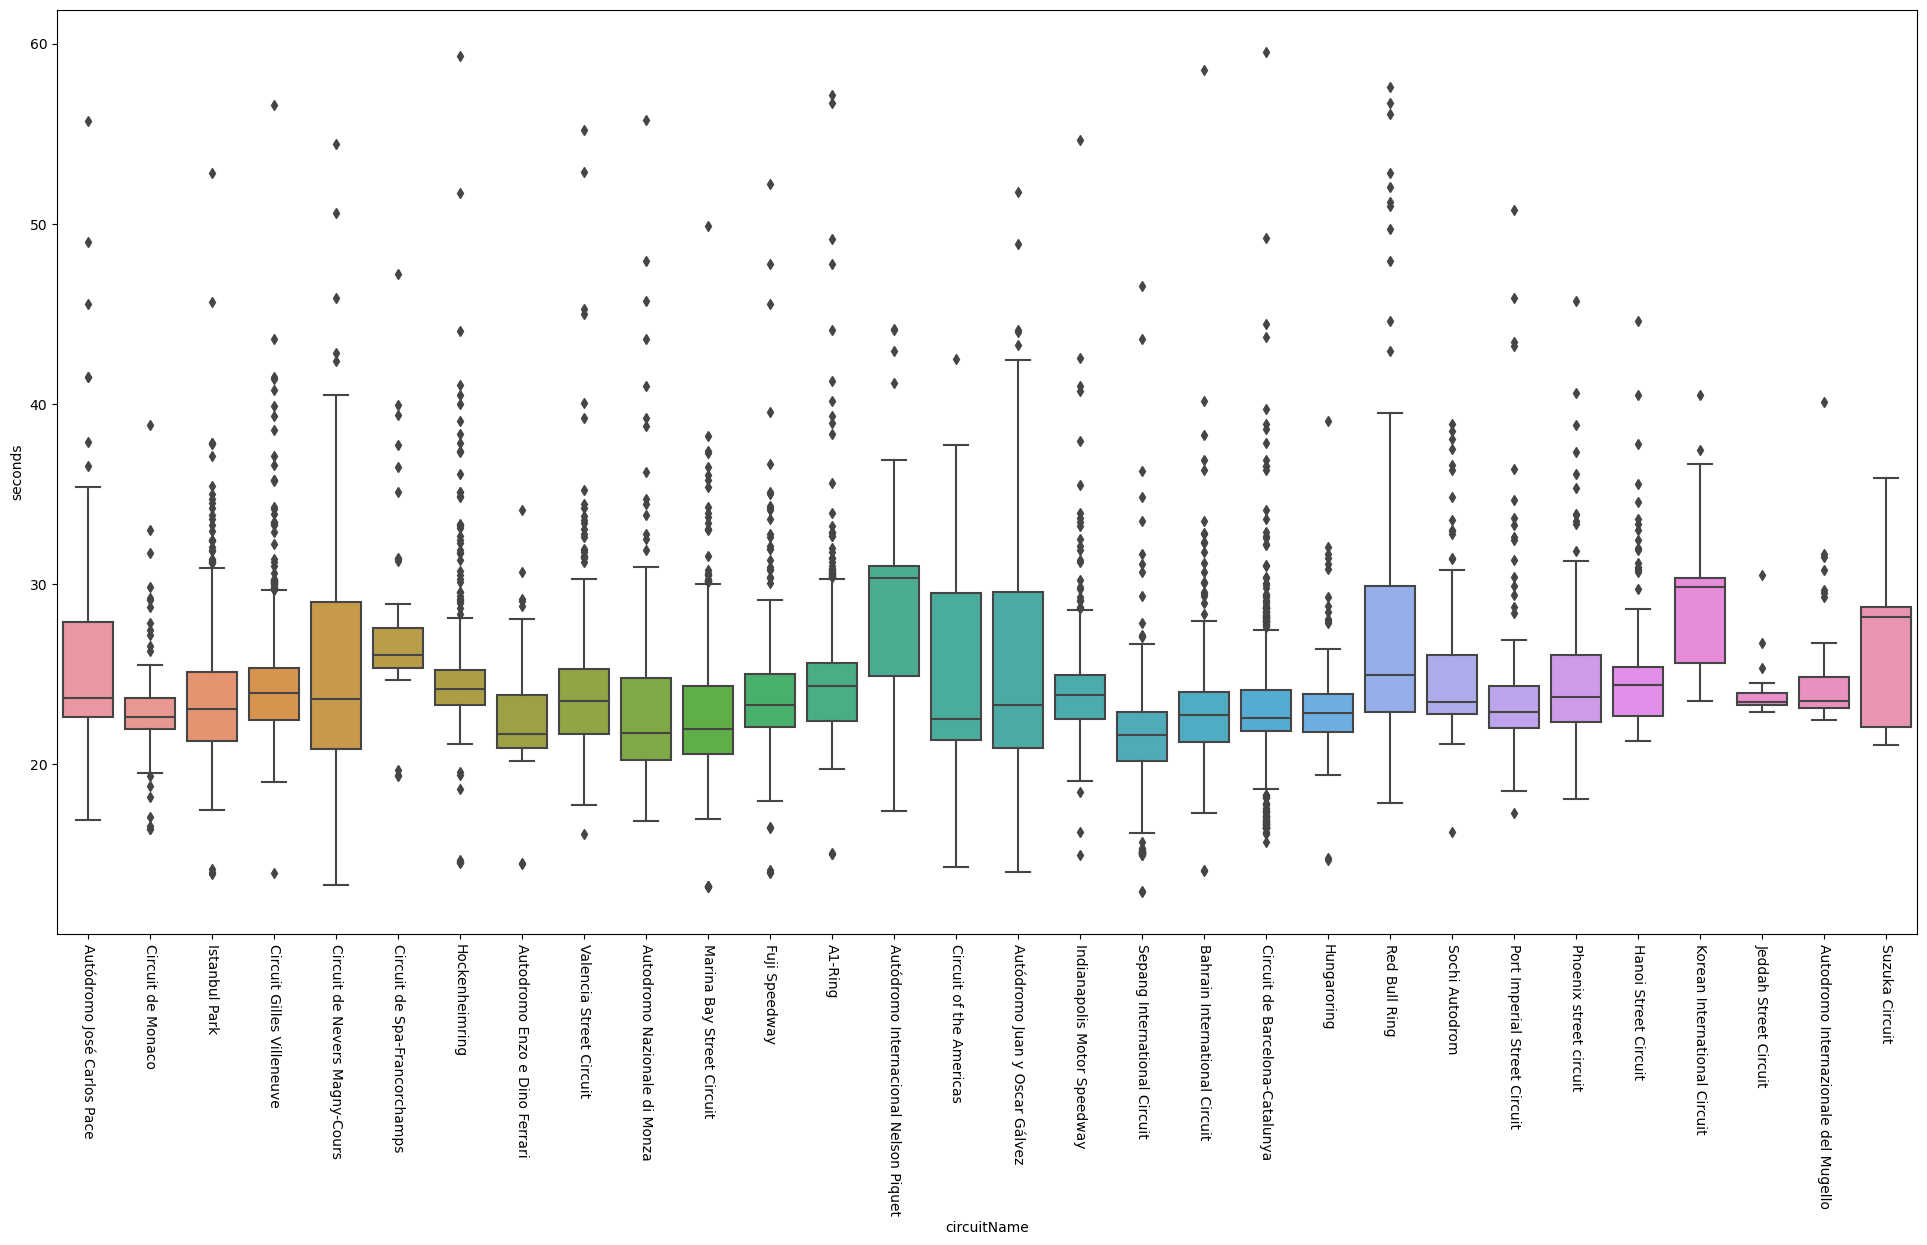

In [27]:
plt.figure(figsize=(24,12))
ax = sns.boxplot(
    x = 'circuitName',
    y = 'seconds',
    data = pit_duration[pit_duration['seconds']<60]
)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)

# Heatmap


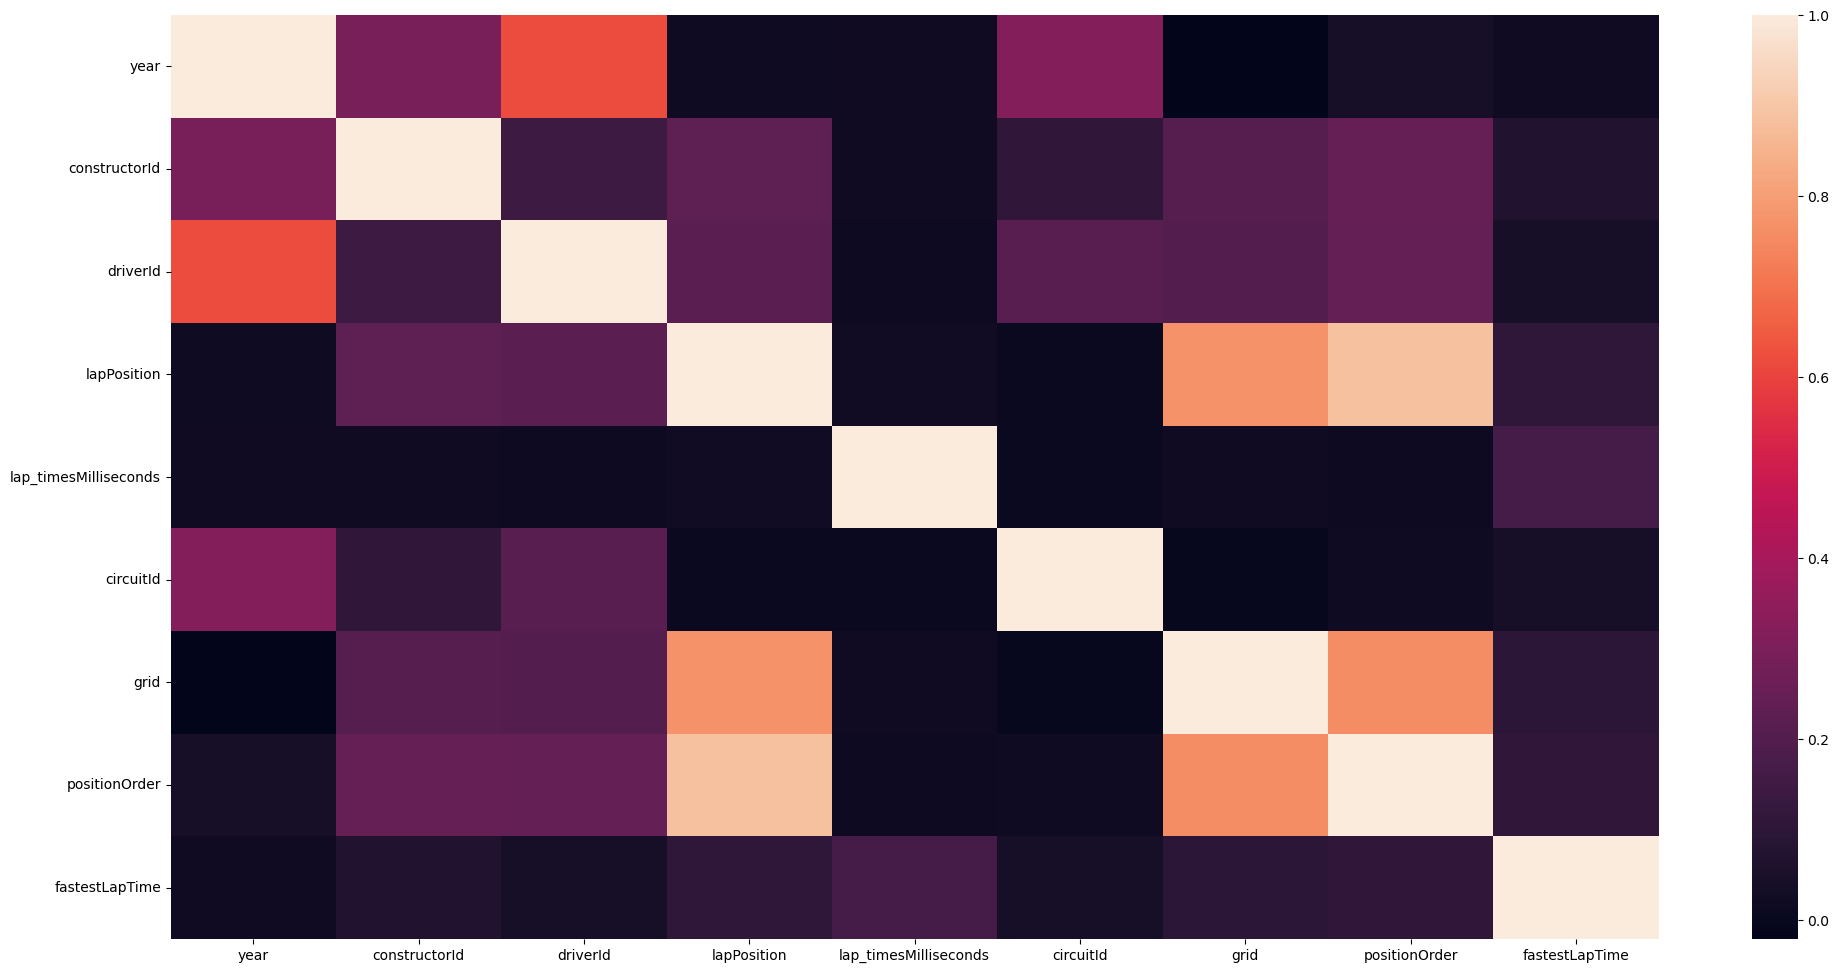

In [28]:
plt.figure(figsize=(24,12))

corr = speedRace[["year","constructorId","driverId","lapPosition","lap_timesMilliseconds","circuitId","grid","positionOrder","fastestLapTime"]].dropna().corr()
sns.heatmap(corr)
plt.show()

# Delta sur le temps d'arrivé des courses

In [29]:
data = pd.merge(races,results,on = 'raceId',how = 'left')
data = data[((data["statusId"] == 1) | data["statusId"].between(11,19)) & (data["year"] >= 2006)] #a partir de 2005 car avant pas forcement le resultat des trois premiers
data = data[["year","driverId","name","raceTimeMilliseconds","position"]]
data = data.dropna()
tab = []
for y in set(data["year"]):
    for n in set(data[data["year"] == y].name):
        val = (data[(data["year"] == y) & (data["name"] == n)].raceTimeMilliseconds.max() - data[(data["year"] == y) & (data["name"] == n)].raceTimeMilliseconds.min())
        mean = data[(data["year"] == y) & (data["name"] == n)].raceTimeMilliseconds.mean()/1000 
        DeltaFirst3 = data.loc[(data["year"] == y) & (data["name"] == n) & (data["position"] == 3),"raceTimeMilliseconds"].values[0] - data.loc[(data["year"] == y) & (data["name"] == n) & (data["position"] == 1),"raceTimeMilliseconds"].values[0]
        tab.append([y,n,val,DeltaFirst3,mean])
        
tab = pd.DataFrame(tab,columns = ['year','circuitName','DeltaRaceTime(ms)',"DeltaFirst3(ms)",'MeanRaceTime(s)'])
tab = tab.drop(92) #Tuscan GP
tab = tab.drop(89) #70th Anniversary Grand Prix
tab = tab.drop(93) #Sakhir Grand Prix
tab = tab.drop(97) #Eifel Grand Prix
tab = tab.drop(111) #Dutch Grand Prix
tab = tab.drop(128) #San Marino Grand Prix

In [38]:
tab[tab["circuitName"] == "Indian Grand Prix"]

,year,circuitName,DeltaRaceTime(ms),DeltaFirst3(ms),MeanRaceTime(s)
202,2011,Indian Grand Prix,84183.0,24301.0,5474.247429
221,2012,Indian Grand Prix,86495.0,13217.0,5519.020714
241,2013,Indian Grand Prix,78951.0,39892.0,5526.919167


[Text(0, 0, 'Abu Dhabi Grand Prix'),
 Text(1, 0, 'Spanish Grand Prix'),
 Text(2, 0, 'Russian Grand Prix'),
 Text(3, 0, 'Mexican Grand Prix'),
 Text(4, 0, 'British Grand Prix'),
 Text(5, 0, 'Japanese Grand Prix'),
 Text(6, 0, 'German Grand Prix'),
 Text(7, 0, 'Malaysian Grand Prix'),
 Text(8, 0, 'Belgian Grand Prix'),
 Text(9, 0, 'Singapore Grand Prix'),
 Text(10, 0, 'Brazilian Grand Prix'),
 Text(11, 0, 'Italian Grand Prix'),
 Text(12, 0, 'Hungarian Grand Prix'),
 Text(13, 0, 'European Grand Prix'),
 Text(14, 0, 'Bahrain Grand Prix'),
 Text(15, 0, 'United States Grand Prix'),
 Text(16, 0, 'Monaco Grand Prix'),
 Text(17, 0, 'Australian Grand Prix'),
 Text(18, 0, 'Chinese Grand Prix'),
 Text(19, 0, 'Canadian Grand Prix'),
 Text(20, 0, 'Austrian Grand Prix'),
 Text(21, 0, 'Azerbaijan Grand Prix'),
 Text(22, 0, 'French Grand Prix'),
 Text(23, 0, 'Styrian Grand Prix'),
 Text(24, 0, 'Portuguese Grand Prix'),
 Text(25, 0, 'Emilia Romagna Grand Prix'),
 Text(26, 0, 'Turkish Grand Prix'),
 Text

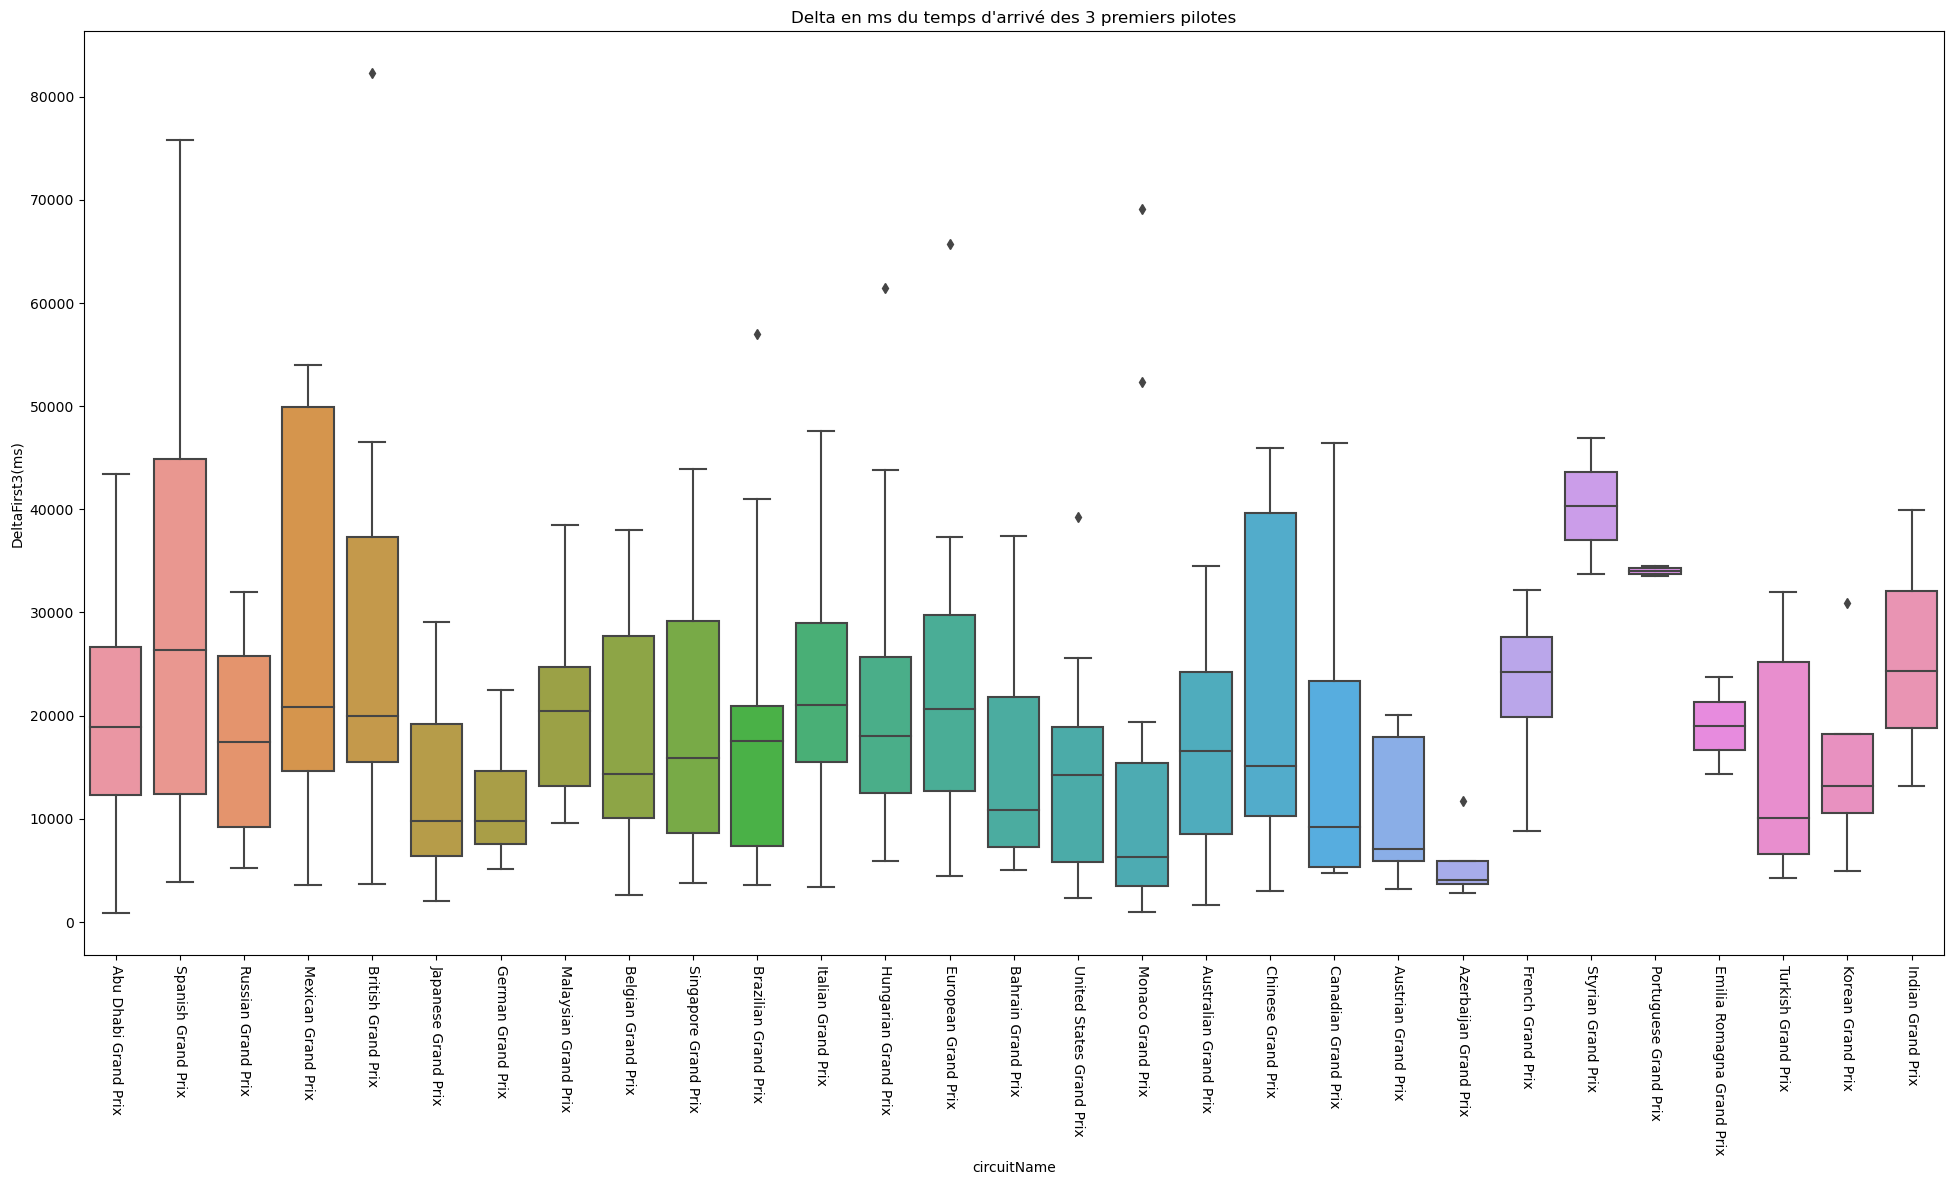

In [36]:
plt.figure(figsize=(24,12))
ax = sns.boxplot(
    x = 'circuitName',
    y = 'DeltaFirst3(ms)',
    data = tab
)
ax.set_title("Delta en ms du temps d'arrivé des 3 premiers pilotes")
ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)

[Text(0, 0, 'Abu Dhabi Grand Prix'),
 Text(1, 0, 'Spanish Grand Prix'),
 Text(2, 0, 'Russian Grand Prix'),
 Text(3, 0, 'Mexican Grand Prix'),
 Text(4, 0, 'British Grand Prix'),
 Text(5, 0, 'Japanese Grand Prix'),
 Text(6, 0, 'German Grand Prix'),
 Text(7, 0, 'Malaysian Grand Prix'),
 Text(8, 0, 'Belgian Grand Prix'),
 Text(9, 0, 'Singapore Grand Prix'),
 Text(10, 0, 'Brazilian Grand Prix'),
 Text(11, 0, 'Italian Grand Prix'),
 Text(12, 0, 'Hungarian Grand Prix'),
 Text(13, 0, 'European Grand Prix'),
 Text(14, 0, 'Bahrain Grand Prix'),
 Text(15, 0, 'United States Grand Prix'),
 Text(16, 0, 'Monaco Grand Prix'),
 Text(17, 0, 'Australian Grand Prix'),
 Text(18, 0, 'Chinese Grand Prix'),
 Text(19, 0, 'Canadian Grand Prix'),
 Text(20, 0, 'Austrian Grand Prix'),
 Text(21, 0, 'Azerbaijan Grand Prix'),
 Text(22, 0, 'French Grand Prix'),
 Text(23, 0, 'Styrian Grand Prix'),
 Text(24, 0, 'Portuguese Grand Prix'),
 Text(25, 0, 'Emilia Romagna Grand Prix'),
 Text(26, 0, 'Turkish Grand Prix'),
 Text

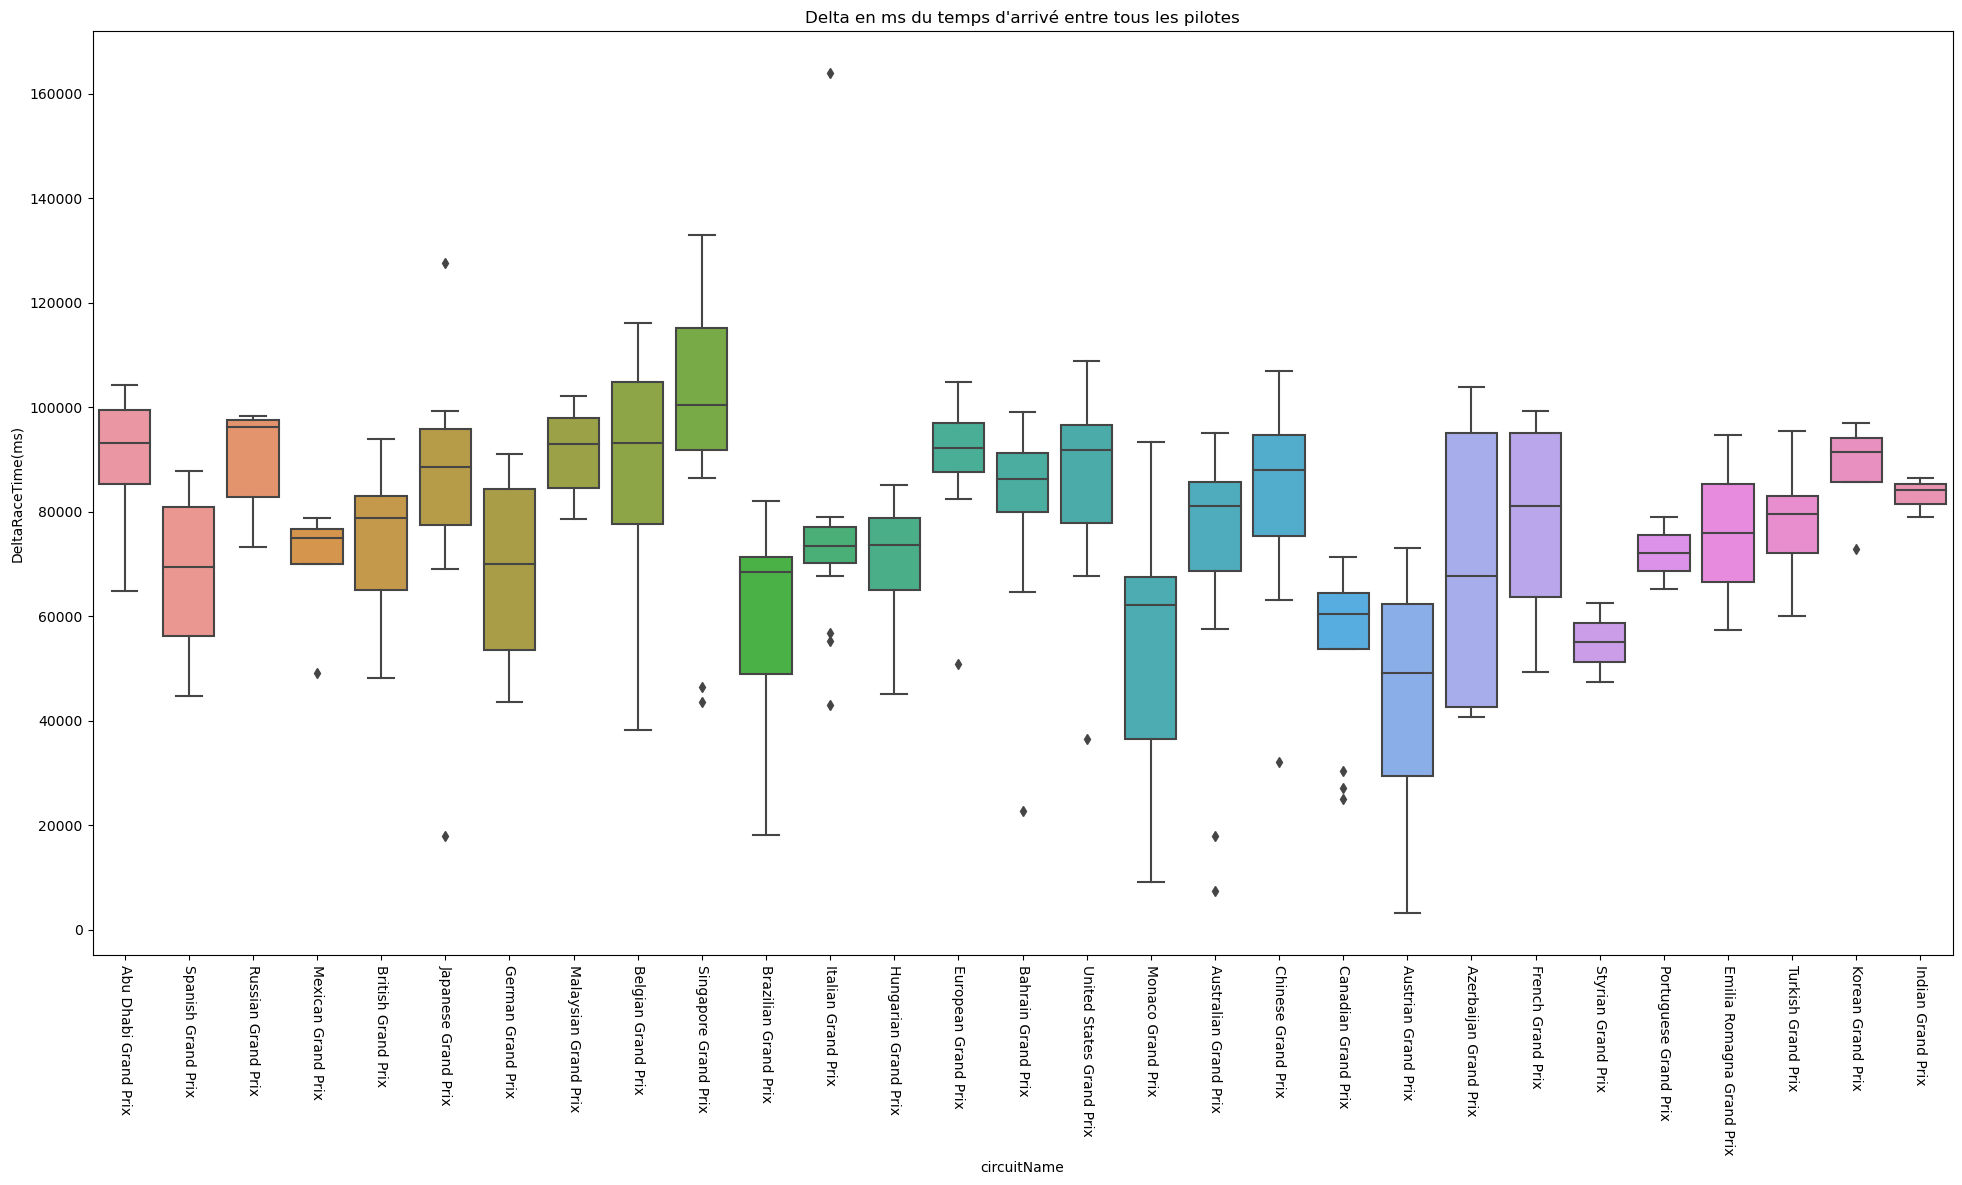

In [37]:
plt.figure(figsize=(24,12))
ax = sns.boxplot(
    x = 'circuitName',
    y = 'DeltaRaceTime(ms)',
    data = tab
)
ax.set_title("Delta en ms du temps d'arrivé entre tous les pilotes")
ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)

# Delta Places

In [52]:
df = pd.merge(races,results,on = 'raceId',how = 'left')
df = df[((df["statusId"] == 1) | df["statusId"].between(11,19)) & (df["year"] >= 2006)]
df = df[["driverId","year","name","grid","position"]]
t = []
for y in set(df["year"]):
    for n in set(df[df["year"] == y].name):
        pos = 0
        nb = df[(df["year"] == 2016) & (df["name"] == "Abu Dhabi Grand Prix")].driverId.count()
        for p in set(df[(df["year"] == y) & (df["name"] == n)].driverId):
            pos += abs(df.loc[(df["year"] == y) & (df["name"] == n) & (df["driverId"] == p),"grid"].values[0] - df.loc[(df["year"] == y) & (df["name"] == n) & (df["driverId"] == p),"position"].values[0])
        t.append([y,n,pos/nb])



In [53]:
t = pd.DataFrame(t,columns = ['year','circuitName','MeanDeltaPosition'])
t = t.drop(t[t.circuitName == "Tuscan Grand Prix"].index.values[0]) #Tuscan GP
t = t.drop(t[t.circuitName == "70th Anniversary Grand Prix"].index.values[0]) #70th Anniversary Grand Prix
t = t.drop(t[t.circuitName == "Sakhir Grand Prix"].index.values[0]) #Sakhir Grand Prix
t = t.drop(t[t.circuitName == "Eifel Grand Prix"].index.values[0]) #Eifel Grand Prix
t = t.drop(t[t.circuitName == "Dutch Grand Prix"].index.values[0]) #Dutch Grand Prix
t = t.drop(t[t.circuitName == "San Marino Grand Prix"].index.values[0]) #San Marino Grand Prixt = pd.DataFrame(t,columns = ['year','circuitName','DeltaPosition'])
t


,year,circuitName,MeanDeltaPosition
0,2016,Austrian Grand Prix,3.176471
1,2016,Italian Grand Prix,1.823529
2,2016,United States Grand Prix,4.000000
3,2016,Russian Grand Prix,4.352941
4,2016,Chinese Grand Prix,3.764706
...,...,...,...
293,2015,Belgian Grand Prix,3.235294
294,2015,Monaco Grand Prix,2.294118
295,2015,Spanish Grand Prix,2.352941
296,2015,Bahrain Grand Prix,2.294118


[Text(0, 0, 'Austrian Grand Prix'),
 Text(1, 0, 'Italian Grand Prix'),
 Text(2, 0, 'United States Grand Prix'),
 Text(3, 0, 'Russian Grand Prix'),
 Text(4, 0, 'Chinese Grand Prix'),
 Text(5, 0, 'European Grand Prix'),
 Text(6, 0, 'Brazilian Grand Prix'),
 Text(7, 0, 'Australian Grand Prix'),
 Text(8, 0, 'Malaysian Grand Prix'),
 Text(9, 0, 'Japanese Grand Prix'),
 Text(10, 0, 'British Grand Prix'),
 Text(11, 0, 'Canadian Grand Prix'),
 Text(12, 0, 'German Grand Prix'),
 Text(13, 0, 'Mexican Grand Prix'),
 Text(14, 0, 'Singapore Grand Prix'),
 Text(15, 0, 'Hungarian Grand Prix'),
 Text(16, 0, 'Belgian Grand Prix'),
 Text(17, 0, 'Monaco Grand Prix'),
 Text(18, 0, 'Spanish Grand Prix'),
 Text(19, 0, 'Bahrain Grand Prix'),
 Text(20, 0, 'Abu Dhabi Grand Prix'),
 Text(21, 0, 'Azerbaijan Grand Prix'),
 Text(22, 0, 'French Grand Prix'),
 Text(23, 0, 'Turkish Grand Prix'),
 Text(24, 0, 'Emilia Romagna Grand Prix'),
 Text(25, 0, 'Styrian Grand Prix'),
 Text(26, 0, 'Portuguese Grand Prix'),
 Text

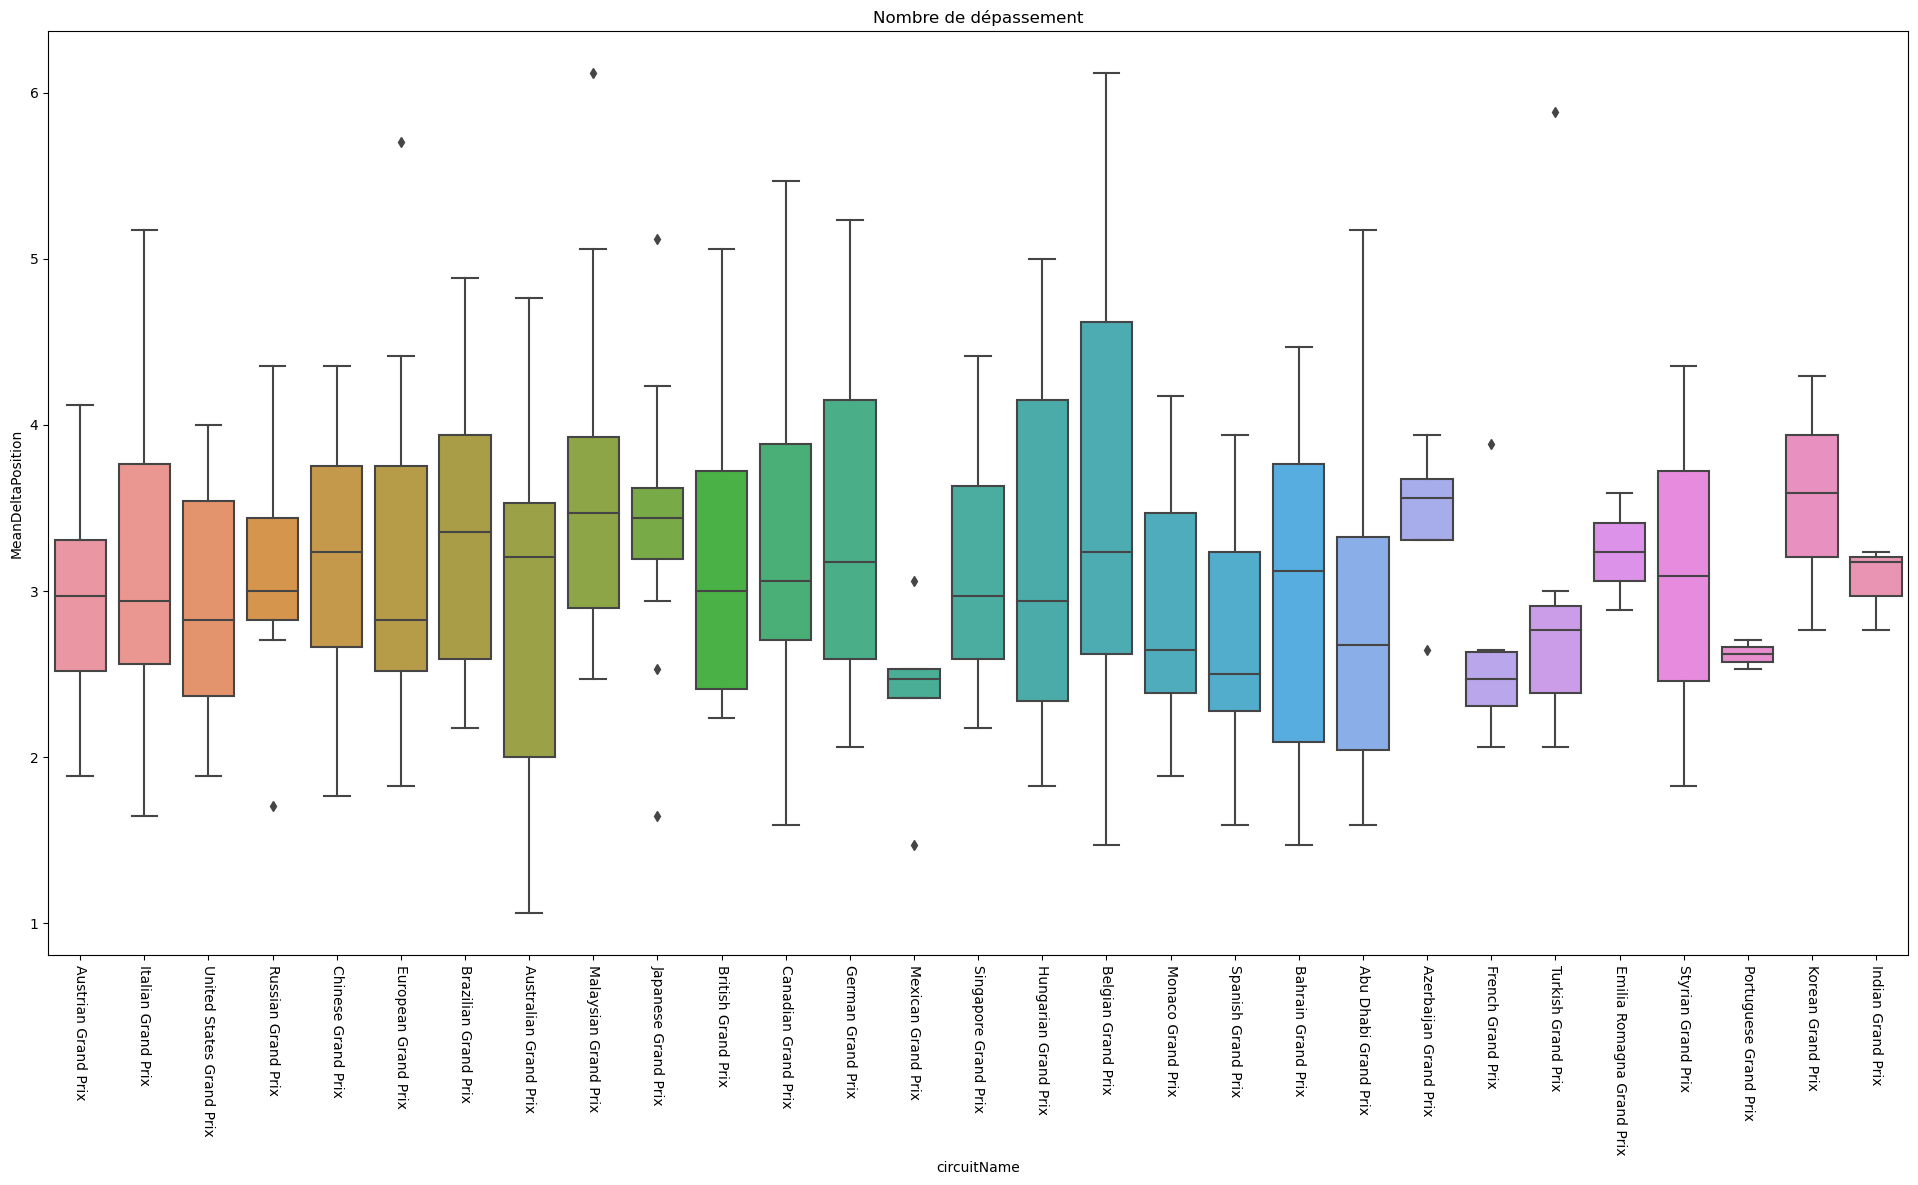

In [54]:
plt.figure(figsize=(24,12))
ax = sns.boxplot(
    x = 'circuitName',
    y = 'MeanDeltaPosition',
    data = t
)
ax.set_title("Nombre de dépassement")
ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)

In [44]:
df[(df["year"] == 2016) & (df["name"] == "Abu Dhabi Grand Prix")].driverId.count()

17